In [95]:
import os
from glob import glob
from datetime import datetime, timedelta

import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 200)

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

plt.style.use('ggplot')
plt.rcParams["font.family"] = 'NanumGothic'
mpl.rcParams['axes.unicode_minus'] = False

In [92]:
# 데이터를 불러오기 위한 함수들
def get_channel_path(ls):
    name_list = list(map(lambda x: x.split('\\')[-1], ls))
    path_list = ls[:]
    return {i:j for i, j in zip(name_list, path_list)}

def get_meta_data(path):
    file_name = path.split('\\')[-1] + '_meta.csv'
    meta_path = os.path.join(path, file_name)
    result = pd.read_csv(meta_path)
    title = result['channel'].value_counts().index.tolist()[0]
    result = result[result['channel'] == title].reset_index(drop=True)
    result['date'] = pd.to_datetime(result['date'])
    return result

def integrate_data(path_list, order:'트렌드 데이터 불러올때만 사용'=None, option='meta'):
    if option =='meta':
        result = pd.DataFrame()
        for p in path_list:
            temp = get_meta_data(p)
            result = pd.concat([result, temp], axis=0, ignore_index=True)
        order_list = result.sort_values(by=['subscribe'], ascending=False)['channel'].unique().tolist()
        return (result
                .sort_values(by='subscribe', ascending=False)
                .groupby('channel')
                .apply(lambda x: x.sort_values(by='date', ascending=True))
                .loc[order_list, :]
                .reset_index(drop=True))
    else:
        result = pd.DataFrame()
        for path in path_list:
            temp = pd.read_csv(path)
            channel = path.split('_')[-1].split('.')[0]
            temp['channel'] = channel
            temp['date'] = pd.to_datetime(temp['date'])
            result = pd.concat([result, temp], ignore_index=True)
        try:
            return pd.concat([result[result['channel']==order[i]] for i in range(len(order))], ignore_index=True)
        except:
            return result
        
pop_channels = get_channel_path(glob('../raw/#1. channel data - popular/*'))
unpop_channels = get_channel_path(glob('../raw/#1. channel data - unpopular/*'))

pop_trend_path = glob('../raw/#2. subscribe trend data/popular/*')
unpop_trend_path = glob('../raw/#2. subscribe trend data/unpopular/*')

#### Data Load & Cleansing

In [93]:
pop_meta = integrate_data(list(pop_channels.values()), option='meta')
unpop_meta = integrate_data(list(unpop_channels.values()), option='meta')
all_meta = pd.concat([pop_meta, unpop_meta], axis=0, ignore_index=True)

# 시각화를 위한 채널 순서
pop_order = pop_meta['channel'].unique().tolist()
unpop_order = unpop_meta['channel'].unique().tolist()

# 구독자 추이 데이터
pop_trend = integrate_data(pop_trend_path, order=pop_order, option='trend')
unpop_trend = integrate_data(unpop_trend_path, order=unpop_order, option='trend')

# 시각화를 위한 색상값
pop_colors = sns.color_palette("RdYlGn", n_colors=len(pop_order)+len(unpop_order))[:len(pop_order)]
unpop_colors = sns.color_palette("RdYlGn", n_colors=len(pop_order)+len(unpop_order))[len(pop_order):]

# 댓글 사용 중지 영상 댓글 수 0처리
pop_meta.loc[pop_meta['comment'] == '댓글 사용 중지', 'comment'] = 0
pop_meta['comment'] = pop_meta['comment'].astype(int)
unpop_meta.loc[unpop_meta['comment'] == '댓글 사용 중지', 'comment'] = 0
unpop_meta['comment'] = unpop_meta['comment'].astype(int)

# 업로드 주기 변수 추가
interval_col = pop_meta.groupby('channel').apply(lambda x: (x['date'] - x['date'].shift()).apply(lambda x: x.days)).to_frame().reset_index()[['channel', 'date']].rename({'date': 'interval'}, axis=1)
pop_meta['interval'] = interval_col['interval']

interval_col = unpop_meta.groupby('channel').apply(lambda x: (x['date'] - x['date'].shift()).apply(lambda x: x.days)).to_frame().reset_index()[['channel', 'date']].rename({'date': 'interval'}, axis=1)
unpop_meta['interval'] = interval_col['interval']

In [94]:
pop_meta

channel  subscribe  \
0     Hongyu ASMR 홍유  6300000.0   
1     Hongyu ASMR 홍유  6300000.0   
2     Hongyu ASMR 홍유  6300000.0   
3     Hongyu ASMR 홍유  6300000.0   
4     Hongyu ASMR 홍유  6300000.0   
...              ...        ...   
7179             야식이  1030000.0   
7180             야식이  1030000.0   
7181             야식이  1030000.0   
7182             야식이  1030000.0   
7183             야식이  1030000.0   

                                                  title    view  duration  \
0                  Korean Pork Cutlet ASMR 돈까스 리얼사운드 먹방  263811     13.07   
1     명랑핫도그 리얼사운드 먹방 ASMR (모짜렐라, 점보, 감자핫도그) + Corn D...  337689      5.72   
2     교촌 허니콤보 리얼사운드 ASMR *Honey Chicken* CRUNCHY EAT...  649025      8.80   
3     *BIG BITES* ASMR SUSHI ROLL EATING SHOW + 연어롤 ...  168184      6.03   
4     BHC 치즈볼과 뿌링클소스 리얼사운드 먹방(노토킹) + CHEESE BALL ASM...  252012      6.98   
...                                                 ...     ...       ...   
7179              엄청난양!족발보쌈세트 大짜..막국수 30분안에 다먹으면 2백만원!!  311871     23.13   
7180                치즈닭갈비 대창닭갈비 라면사리..30분안에 다먹으면 5백만원!!  130731     18.95   
7181      얼큰해진 참깨라면?? 열려라참깨라면1봉지!! 라죽에 달걀 김가루까지 넣고 묵자!!  325401     17.47   
7182                 함흥물냉면 비빔냉면 묵고 소갈비찜 소갈비탕 소불고기 또묵자!!  144492     21.37   
7183           40년 전통의 떡볶이집! 라볶이 쫄볶이..13접시 다먹으면 100만원!!   92728     23.35   

           date                                        description  comment  \
0    2018-09-29  ASMR 😊\n\n구독과 댓글 꾹! 감사합니다♥\n\n오늘은 집에서 만든 돈까스에요...      602   
1    2018-10-06  안녕하세요! 오늘은 '명랑핫도그' 세가지를 준비했습니다.\n맛있게 잘 먹겠습니다. ...      206   
2    2018-10-07  안녕하세요! 오늘은 '교촌치킨 허니콤보' 입니다.\n너무 맛있어요!\n잘 먹겠습니다...      457   
3    2018-10-13  오늘은 날치알을 얹은 대왕 연어스시롤 먹방입니다. \n잘라먹는 게 더 지저분한 거 ...      157   
4    2018-10-14  안녕하세요! 오늘은 BHC 치즈볼과 뿌링클소스를 준비해봤어요.\n생각보다 너무 맛있...      182   
...         ...                                                ...      ...   
7179 2020-10-29  #족발보쌈세트\n#30분안에\n#다먹으면\n#2백만원\n\n구독하기(Subscrib...      440   
7180 2020-10-31  #홍춘천\n#치즈닭갈비\n#대창닭갈비\n#다먹으면\n#500만원\n\n치즈닭갈비 대...      197   
7181 2020-11-02  #열려라참깨라면\n#참깨라면\n#열라면\n#라죽\n\n구독하기(Subscribe) ...      492   
7182 2020-11-04  #함흥냉면\n#소갈비찜\n#소갈비탕\n#소불고기\n\n구독하기(Subscribe) ...      258   
7183 2020-11-06  #떡볶이\n#라볶이\n#쫄볶이\n#모이자고\n#유관순열사\n\n구독하기(Subscr...      423   

       like  dislike                                          thumbnail  \
0      5890      273  https://i.ytimg.com/vi/JbN2ZD8Qrpw/maxresdefau...   
1      6890      166  https://i.ytimg.com/vi/E_MJiZTmfZg/maxresdefau...   
2     10683      348  https://i.ytimg.com/vi/wUSw6XuJRTA/maxresdefau...   
3      3291      119   https://i.ytimg.com/vi/78B1Upallok/hqdefault.jpg   
4      4663      253  https://i.ytimg.com/vi/1R17A_mYmBA/maxresdefau...   
...     ...      ...                                                ...   
7179   7580      189  https://i.ytimg.com/vi/uJIpqKs9Xdo/maxresdefau...   
7180   4248      109  https://i.ytimg.com/vi/N-opA2JGPKc/maxresdefau...   
7181   6917      170  https://i.ytimg.com/vi/oziZjLh7XLc/maxresdefau...   
7182   4735      116  https://i.ytimg.com/vi/v6vsRrPy42E/maxresdefau...   
7183   4819       66  https://i.ytimg.com/vi/G3i9MkAn1cI/maxresdefau...   

      interval  
0          NaN  
1         20.0  
2         37.0  
3         34.0  
4        121.0  
...        ...  
7179       2.0  
7180       2.0  
7181       2.0  
7182       2.0  
7183       2.0  

[7184 rows x 12 columns]

#### 채널별 구독 현황

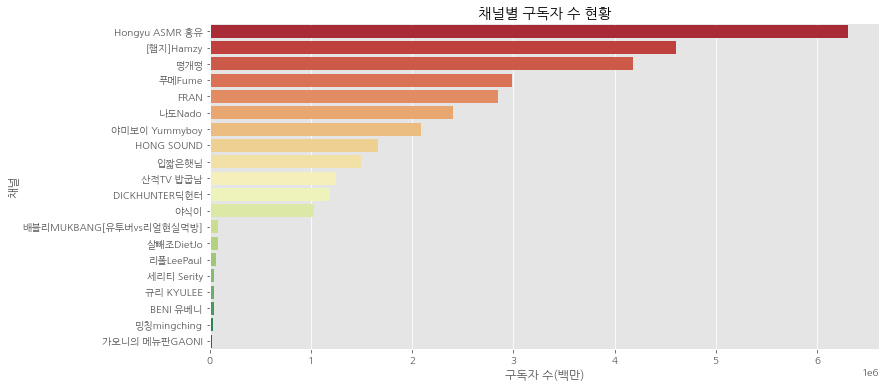

In [7]:
plt.figure(figsize=(12, 6))
sns.barplot(y='channel', x='subscribe', data=all_meta.sort_values(by='subscribe', ascending=False), palette=pop_colors+unpop_colors)
# sns.barplot(x='channel', y='subscribe', data=meta_unpopular, palette='summer')
plt.title('채널별 구독자 수 현황')
plt.ylabel('채널')
plt.xlabel('구독자 수(백만)')
plt.show()

#### 업로드 주기

In [8]:
pop_interval_dist = pop_meta.groupby('channel').apply(lambda x: x['interval'].value_counts() / x.shape[0]).reset_index().rename({'level_1':'interval', 'interval':'percentage'}, axis=1)
unpop_interval_dist = unpop_meta.groupby('channel').apply(lambda x: x['interval'].value_counts() / x.shape[0]).reset_index().rename({'level_1':'interval', 'interval':'percentage'}, axis=1)

In [9]:
print(pop_meta['interval'].mean())
print(pop_meta['interval'].std())

1.8124651422197435
3.522677209548534


In [10]:
print(unpop_meta['interval'].mean())
print(unpop_meta['interval'].std())

6.8786764705882355
10.517020550769201


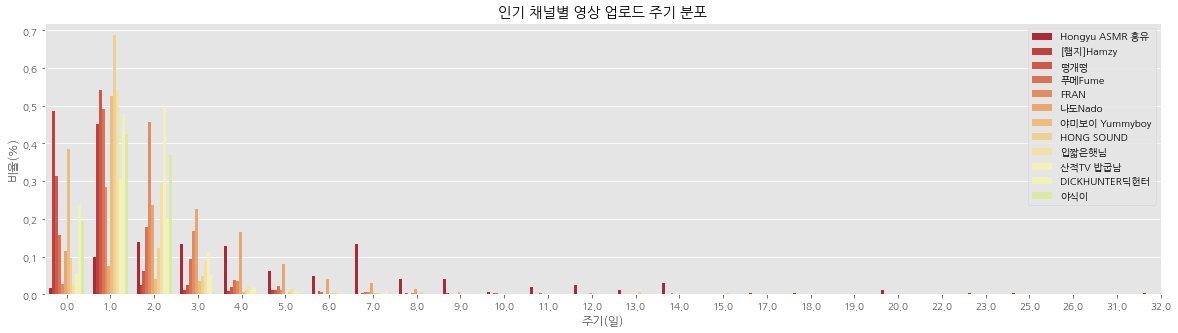

In [11]:
plt.figure(figsize=(20, 5))
sns.barplot(x='interval', y='percentage', hue='channel', hue_order=pop_order, data=pop_interval_dist, palette=pop_colors)
plt.title('인기 채널별 영상 업로드 주기 분포')
plt.ylabel('비율(%)')
plt.xlabel('주기(일)')
plt.xlim(-0.5, 25)
plt.legend(loc='upper right')
plt.show()

업로드 주기가 앞당겨 진 채널일 수록 '떡상 중'인걸까?

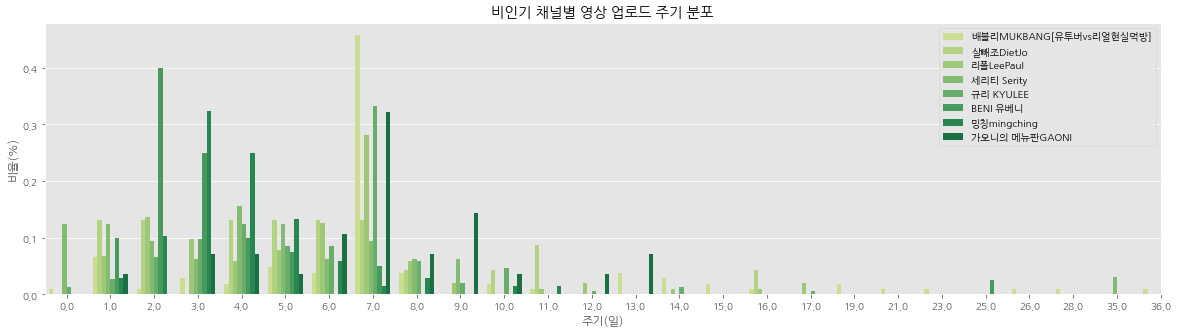

In [12]:
plt.figure(figsize=(20, 5))
sns.barplot(x='interval', y='percentage', hue='channel', hue_order=unpop_order, data=unpop_interval_dist, palette=unpop_colors)
plt.title('비인기 채널별 영상 업로드 주기 분포')
plt.ylabel('비율(%)')
plt.xlabel('주기(일)')
plt.xlim(-0.5, 25)
plt.legend(loc='upper right')
plt.show()

#### 영상 길이

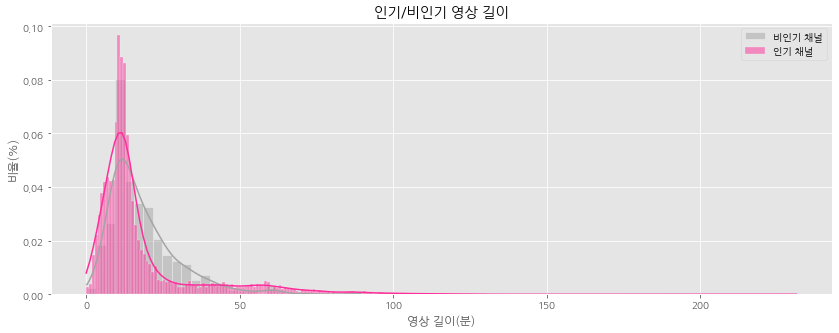

In [13]:
plt.figure(figsize=(14, 5))
sns.histplot(unpop_meta['duration'], kde=True, stat='density', color='#A4A4A4', label='비인기 채널')
sns.histplot(pop_meta['duration'], kde=True, stat='density', color='#FE2E9A', label='인기 채널')
plt.title('인기/비인기 영상 길이')
plt.xlabel('영상 길이(분)')
plt.ylabel('비율(%)')
plt.legend()
plt.show()

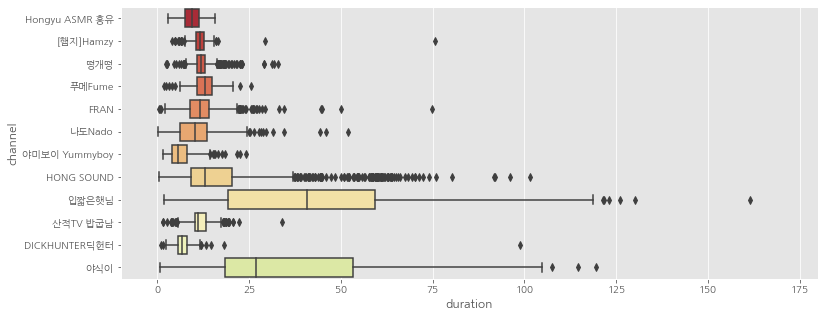

In [14]:
plt.figure(figsize=(12.5, 5))
sns.boxplot(y='channel', x='duration', data=pop_meta, order=pop_order, palette=pop_colors)
plt.xlim(-10, 180)
plt.show()

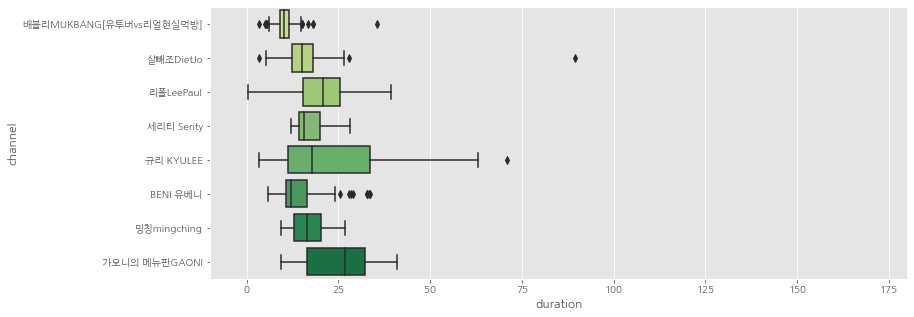

In [15]:
plt.figure(figsize=(12.5, 5))
sns.boxplot(y='channel', x='duration', data=unpop_meta, order=unpop_order, palette=unpop_colors)
plt.xlim(-10, 180)
plt.show()

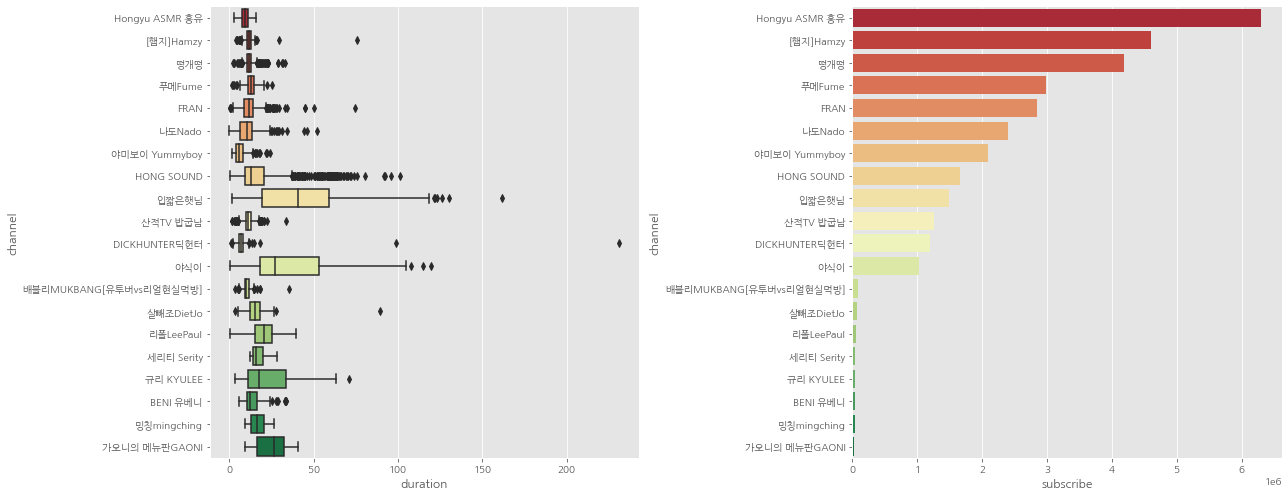

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(18, 7))
sns.boxplot(y='channel', x='duration', data=all_meta, order=pop_order+unpop_order, palette=pop_colors+unpop_colors, ax=ax[0])
sns.barplot(y='channel', x='subscribe', data=all_meta.sort_values(by='subscribe', ascending=False), palette=pop_colors+unpop_colors, ax=ax[1])
plt.tight_layout()
plt.show()

### Hot Ratio
평범한 영상 대비 떡상 영상의 조회수 배율
- '평범한 영상'의 정의?
- '떡상 영상'의 정의?

=> 우선, threshold에 따른 떡상 등장 빈도수를 살펴보고, 기준 백분위를 정해야겠다

In [17]:
deadline = '2019-11-08'

pop_current = pop_meta[pop_meta['date'] >= pd.to_datetime(deadline)]
unpop_current = unpop_meta[unpop_meta['date'] >= pd.to_datetime(deadline)]

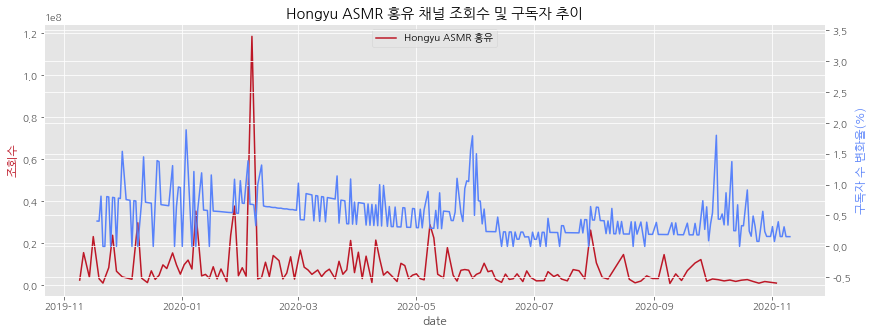

Hot Index(떡상지수): 2.107288230889727


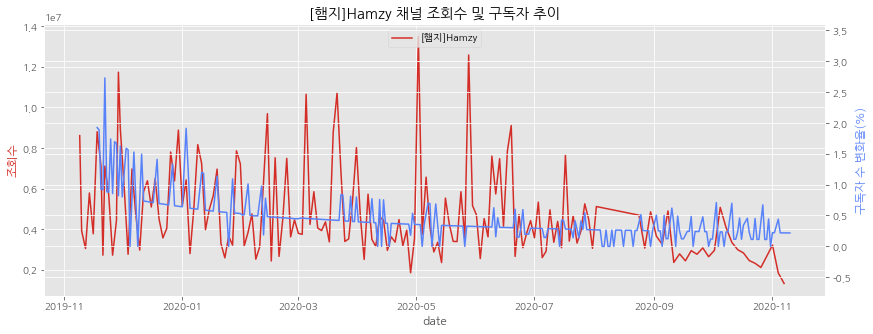

Hot Index(떡상지수): 1.5577113979277037


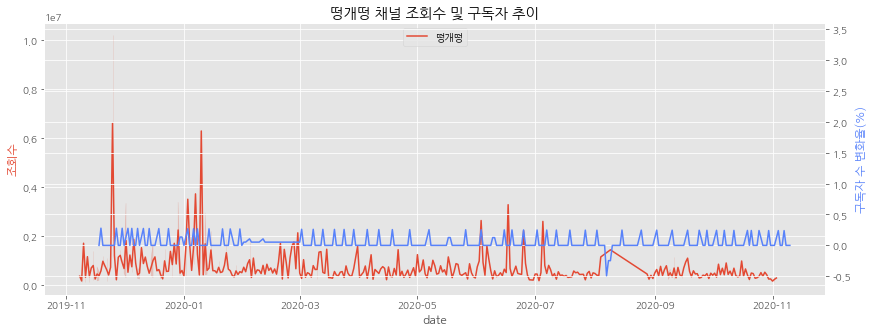

Hot Index(떡상지수): 1.7622230198326705


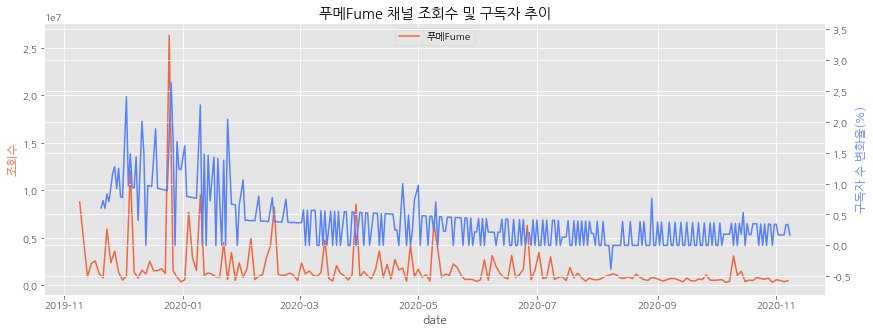

Hot Index(떡상지수): 1.9866030419590883


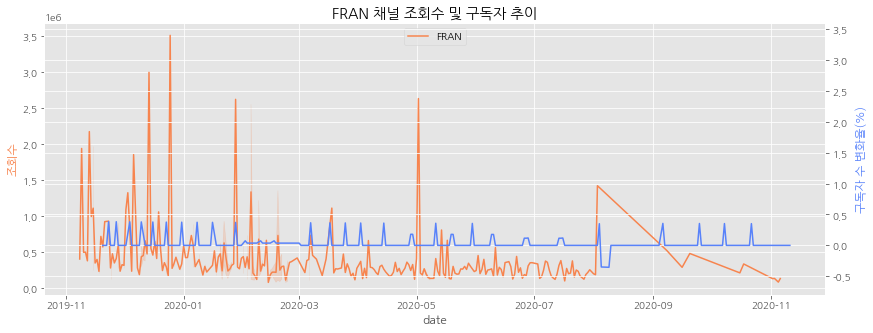

Hot Index(떡상지수): 1.666489514024762


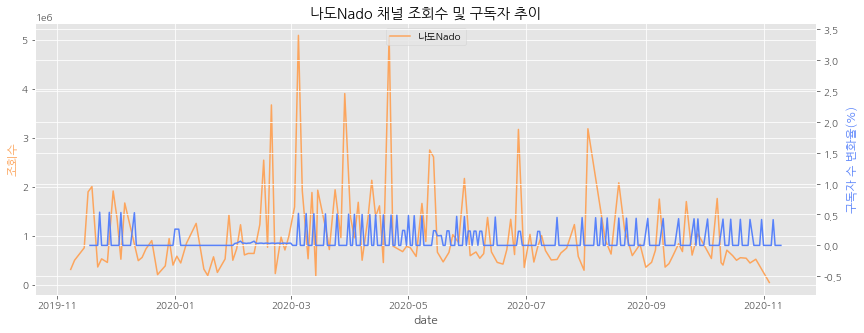

Hot Index(떡상지수): 2.01003332951038


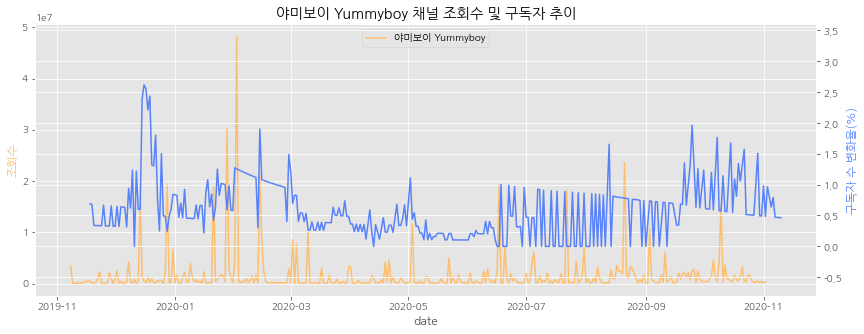

Hot Index(떡상지수): 3.9122083699818835


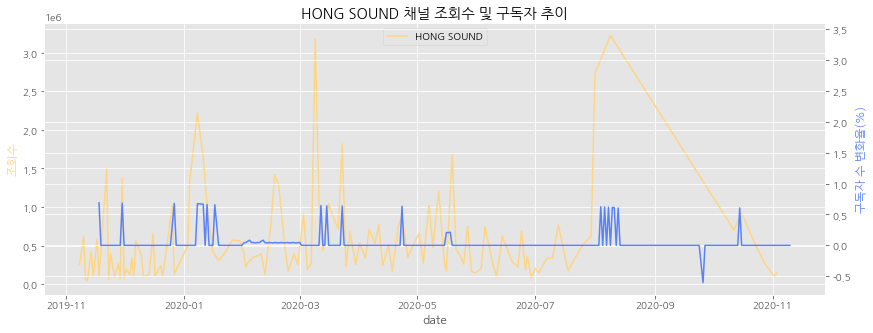

Hot Index(떡상지수): 2.3011437152032754


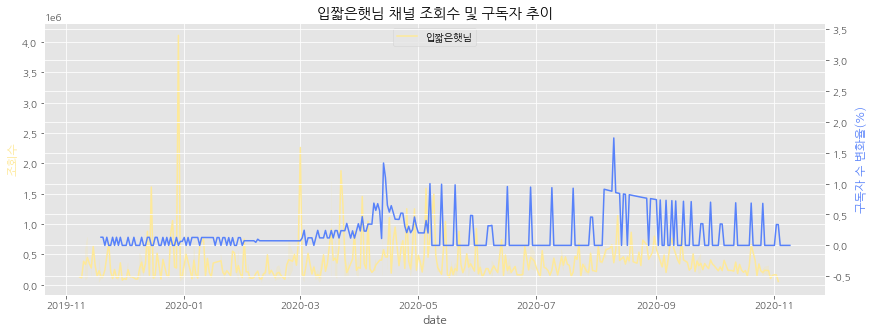

Hot Index(떡상지수): 1.9441218387264194


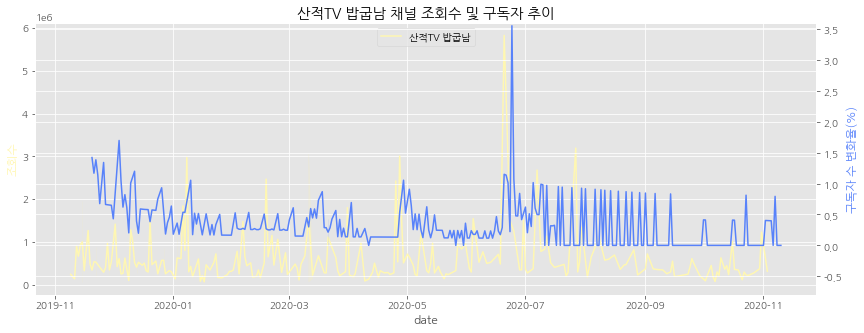

Hot Index(떡상지수): 1.9223697230328831


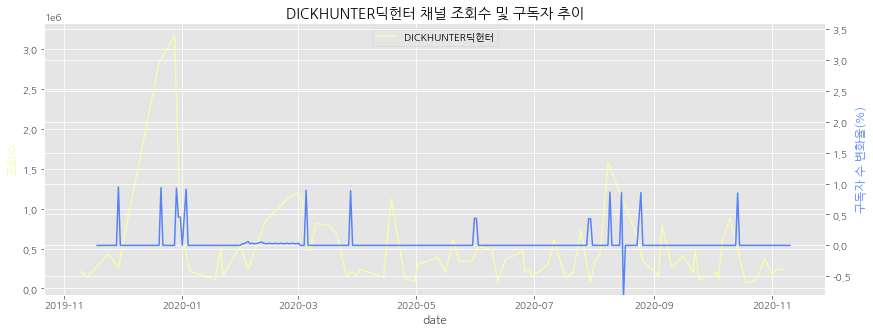

Hot Index(떡상지수): 2.174573211076038


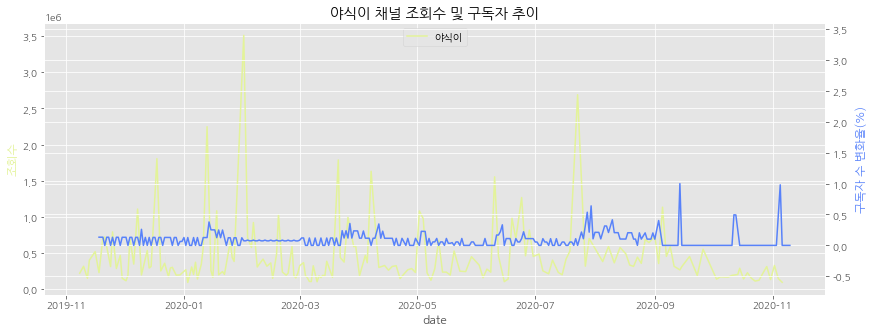

Hot Index(떡상지수): 1.859540673474731


In [44]:
for i in range(len(pop_order)):
    get_trend_pop(idx=i)

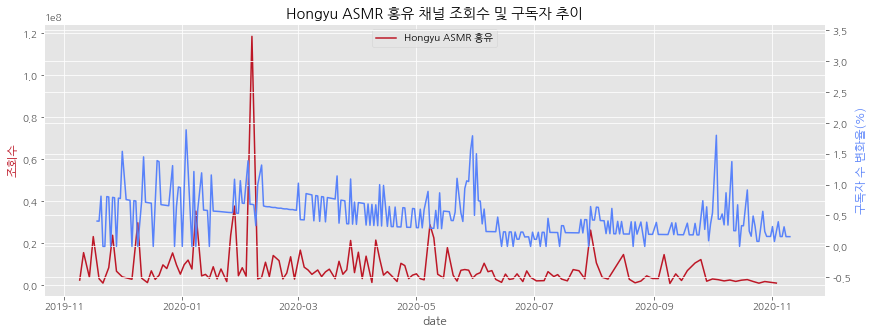

Hot Index(떡상지수): 2.107288230889727


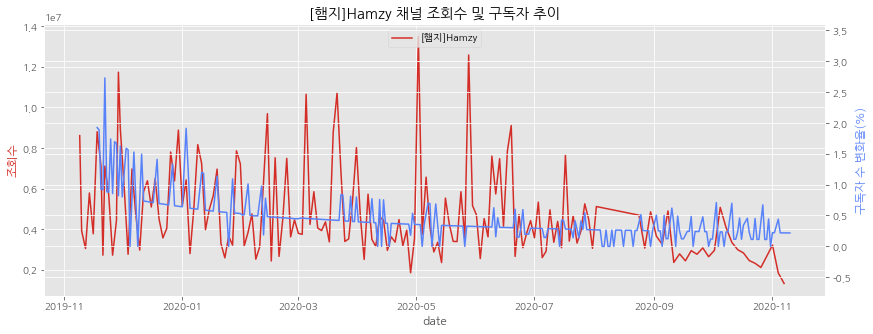

Hot Index(떡상지수): 1.5577113979277037


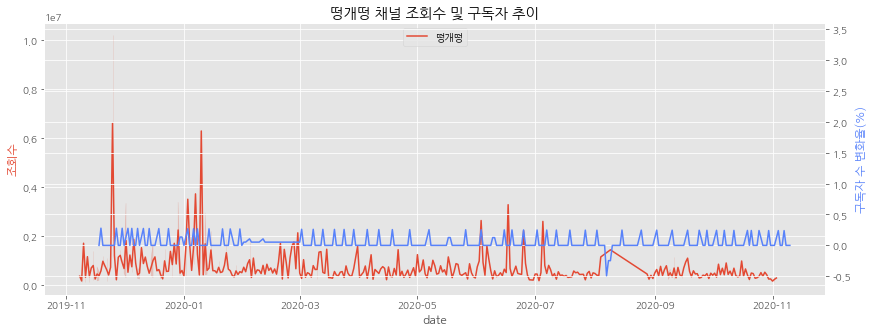

Hot Index(떡상지수): 1.7622230198326705


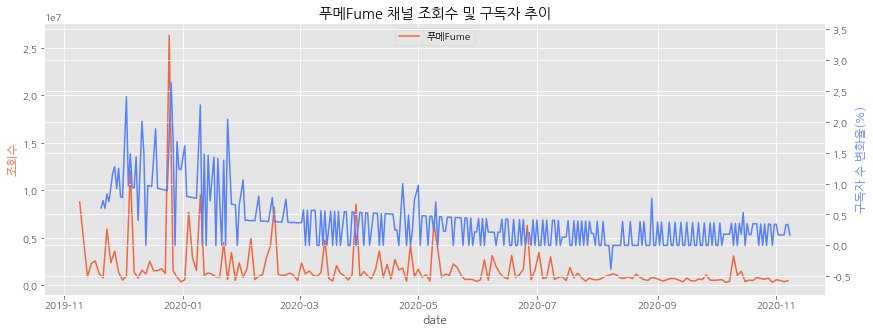

Hot Index(떡상지수): 1.9866030419590883


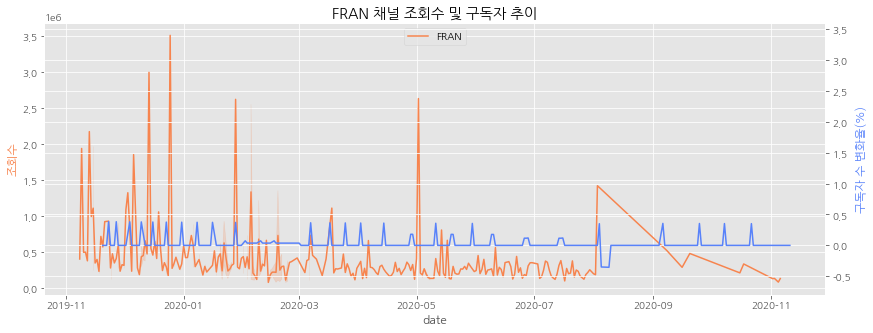

Hot Index(떡상지수): 1.666489514024762


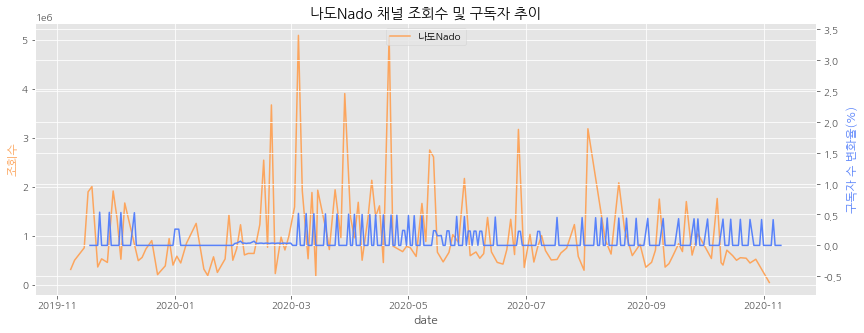

Hot Index(떡상지수): 2.01003332951038


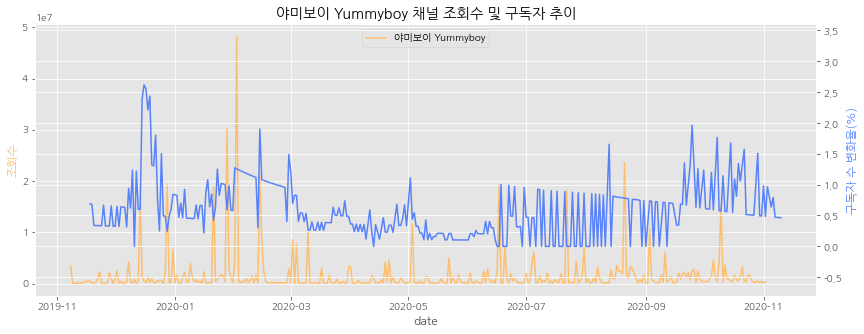

Hot Index(떡상지수): 3.9122083699818835


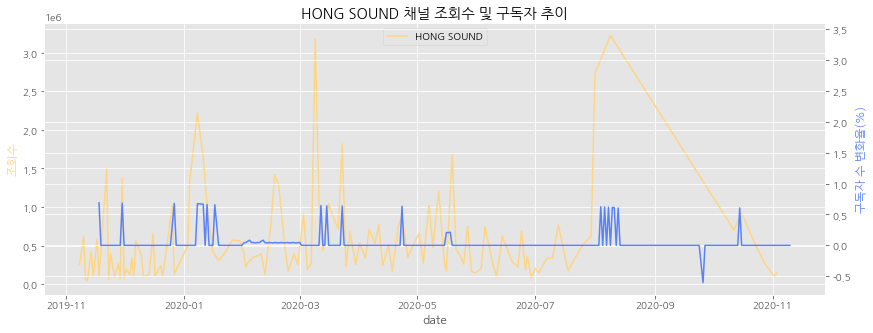

Hot Index(떡상지수): 2.3011437152032754


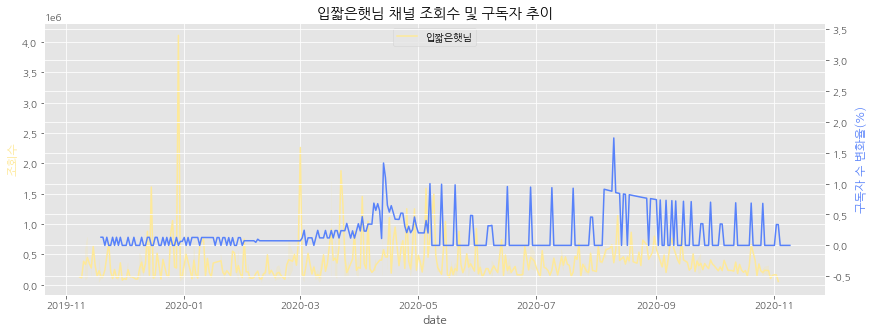

Hot Index(떡상지수): 1.9441218387264194


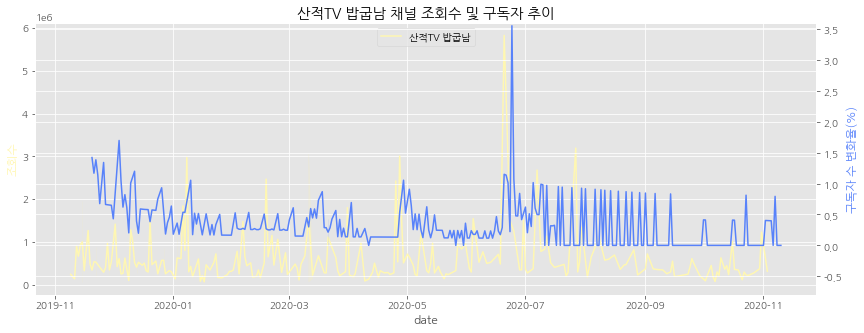

Hot Index(떡상지수): 1.9223697230328831


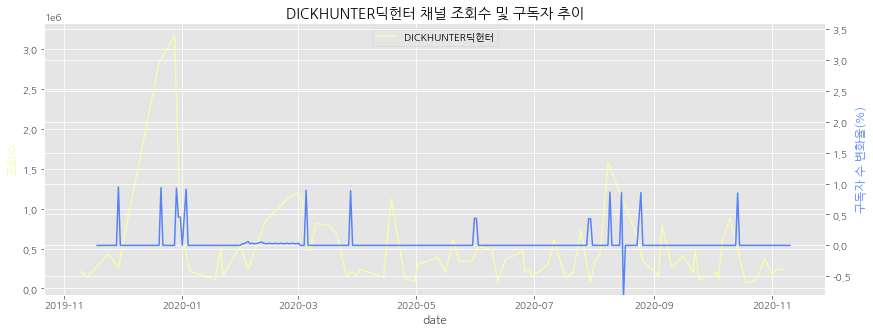

Hot Index(떡상지수): 2.174573211076038


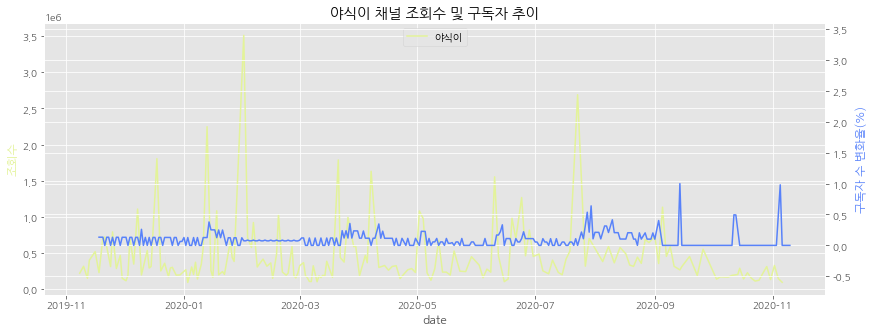

Hot Index(떡상지수): 1.859540673474731


In [50]:
for i in range(len(pop_order)):
    get_trend_pop(idx=i)

In [283]:
view_trend = pop_current[pop_current['channel']==pop_order[idx]]

In [290]:
((view_trend['view'] / view_trend['view'].shift()) - 1) * 100

5117           NaN
5118    -11.067447
5119    243.344625
5120     52.163814
5121    -86.907835
           ...    
5565      5.430113
5566      3.448784
5567     -8.104624
5568    -70.941801
5569     32.811283
Name: view, Length: 453, dtype: float64

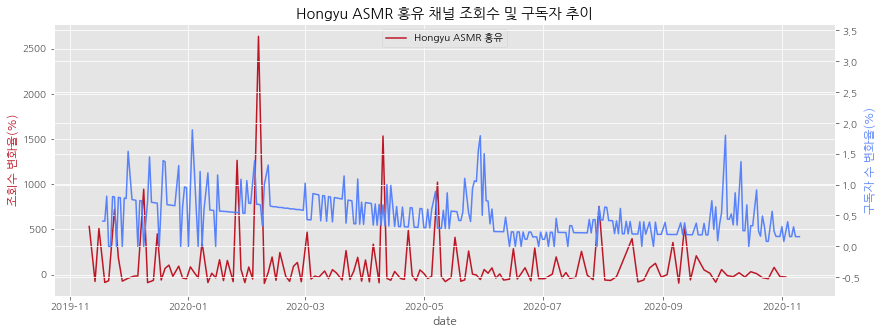

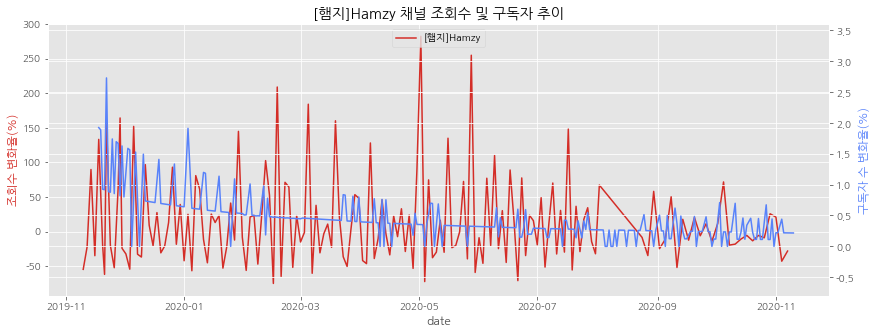

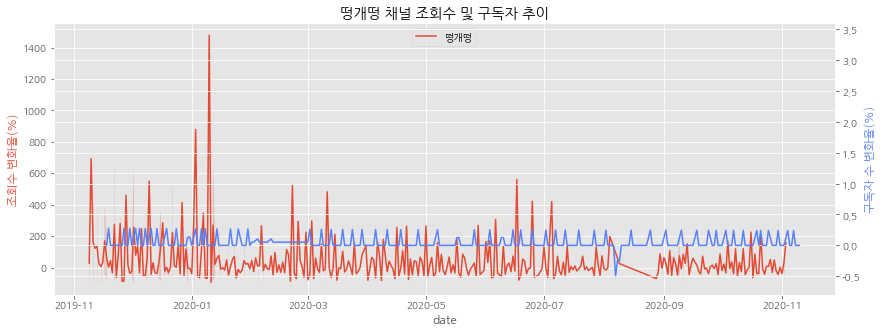

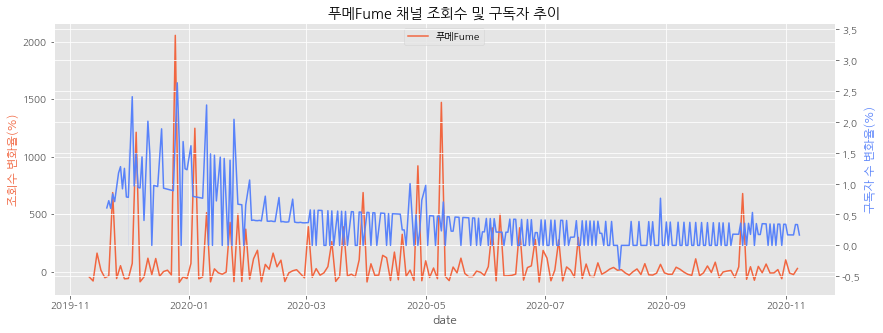

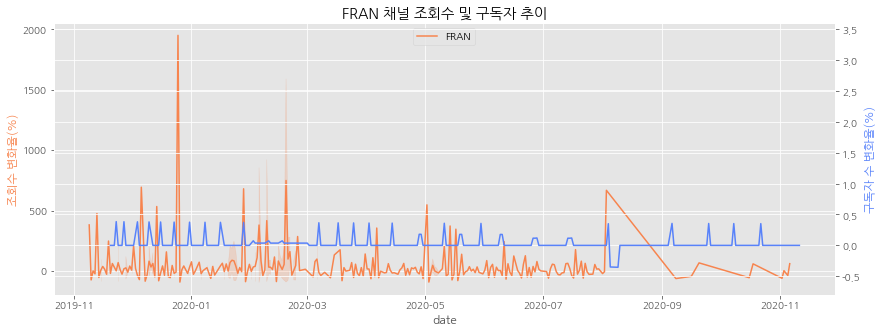

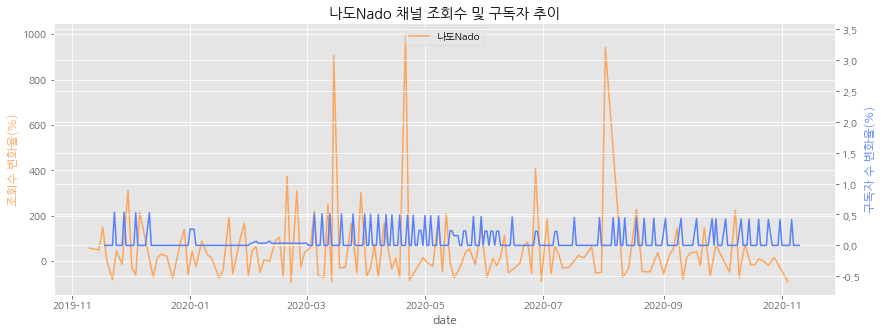

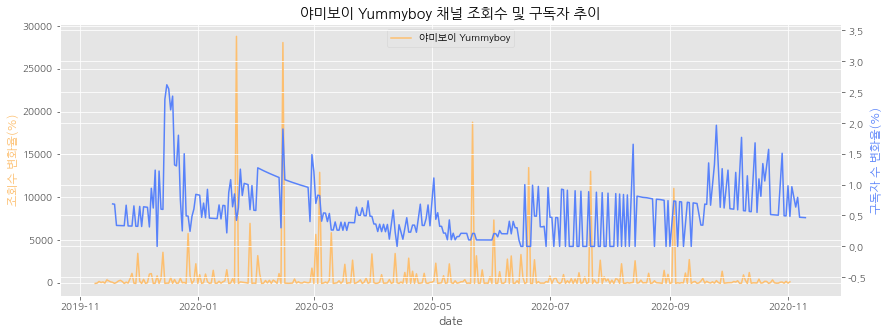

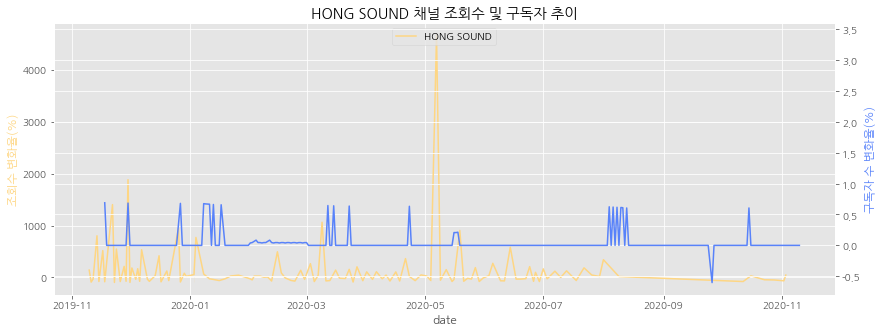

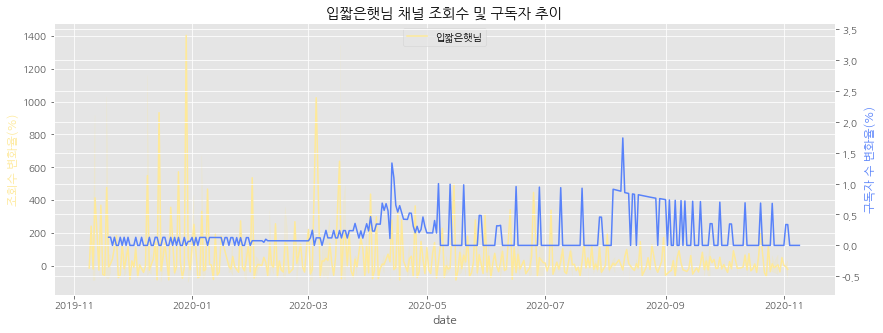

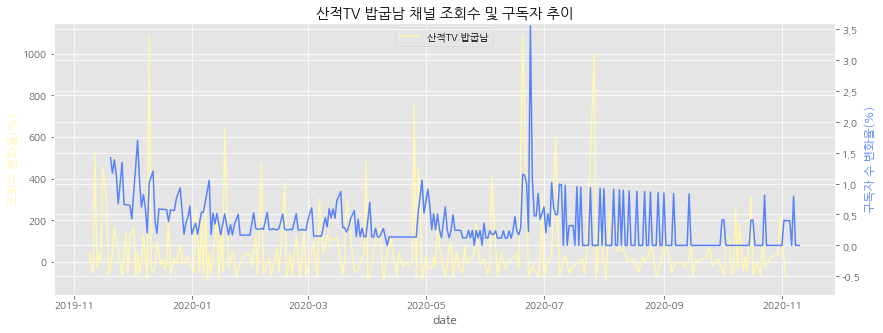

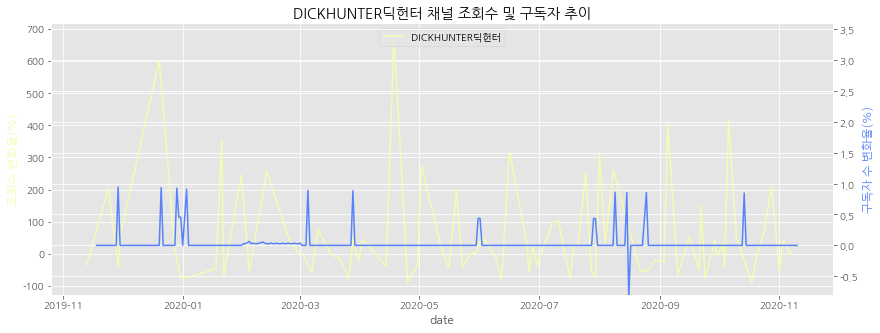

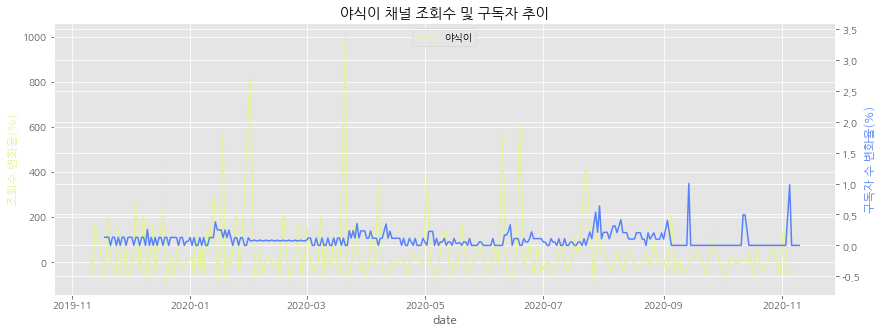

In [22]:
for i in range(len(pop_order)):
    plot_trend_pop_diff(idx=i)

In [21]:
def plot_trend_pop_diff(idx=0):
    subs_trend = pop_trend[pop_trend['channel']==pop_order[idx]].reset_index(drop=True)
    subs_trend['diff_ratio'] = ((subs_trend['subscriber'] / subs_trend['subscriber'].shift()) - 1)*100
    view_trend = pop_current[pop_current['channel']==pop_order[idx]].reset_index(drop=True)
    view_trend['diff_ratio'] = ((view_trend['view'] / view_trend['view'].shift()) - 1) * 100
    
#     n_sub = view_trend['subscribe'].iloc[0] / 10000
#     threshold = view_trend[['view']].describe().loc['75%'].values[0]
    
    fig, ax = plt.subplots(figsize=(14, 5))
    
    # 조회수 추이
    sns.lineplot(x='date', y='diff_ratio', data=view_trend, label=pop_order[idx], color=pop_colors[idx], ax=ax)
#     sns.lineplot(x='date', y='view', data=view_trend, label=pop_order[idx], color=pop_colors[idx], ax=ax)
    ax.set_ylabel('조회수 변화율(%)', color=pop_colors[idx])
#     ax.set_ylim(-200, 4000)
    
    # 구독자 수 추이
    ax_twin = ax.twinx()
    sns.lineplot(x='date', y='diff_ratio', data=subs_trend, color='#5882FA', ax=ax_twin)
    ax_twin.set_ylabel('구독자 수 변화율(%)', color='#5882FA')
    ax_twin.set_ylim(-0.8, 3.6)
#     ax_twin.hlines(y=0, xmin=deadline, xmax=subs_trend['date'].max(), color='gray')
    ax.legend(loc='upper center')

    ax.legend(loc='upper center')
    ax.set_title(f'{pop_order[idx]} 채널 조회수 및 구독자 추이')
    plt.show()
#     print('Hot Index(떡상지수):', threshold / view_trend[view_trend['view'] < threshold][['view']].mean().values[0])

In [31]:
def plot_trend_unpop_diff(idx=0):
    subs_trend = unpop_trend[unpop_trend['channel']==unpop_order[idx]].reset_index(drop=True)
    subs_trend['diff_ratio'] = ((subs_trend['subscriber'] / subs_trend['subscriber'].shift()) - 1)*100
    view_trend = unpop_current[unpop_current['channel']==unpop_order[idx]].reset_index(drop=True)
    view_trend['diff_ratio'] = ((view_trend['view'] / view_trend['view'].shift()) - 1) * 100
    
#     n_sub = view_trend['subscribe'].iloc[0] / 10000
#     threshold = view_trend[['view']].describe().loc['75%'].values[0]
    
    fig, ax = plt.subplots(figsize=(14, 5))
    
    # 조회수 추이
    sns.lineplot(x='date', y='diff_ratio', data=view_trend, label=unpop_order[idx], color=unpop_colors[idx], ax=ax)
#     sns.lineplot(x='date', y='view', data=view_trend, label=unpop_order[idx], color=unpop_colors[idx], ax=ax)
    ax.set_ylabel('조회수 변화율(%)', color=unpop_colors[idx])
#     ax.set_ylim(-200, 4000)
    
    # 구독자 수 추이
    ax_twin = ax.twinx()
    sns.lineplot(x='date', y='diff_ratio', data=subs_trend, color='#5882FA', ax=ax_twin)
    ax_twin.set_ylabel('구독자 수 변화율(%)', color='#5882FA')
#     ax_twin.set_ylim(-0.8, 3.6)
#     ax_twin.hlines(y=0, xmin=deadline, xmax=subs_trend['date'].max(), color='gray')
    ax.legend(loc='upper center')

    ax.legend(loc='upper center')
    ax.set_title(f'{unpop_order[idx]} 채널 조회수 및 구독자 추이')
    plt.show()
#     print('Hot Index(떡상지수):', threshold / view_trend[view_trend['view'] < threshold][['view']].mean().values[0])

In [33]:
def plot_trend_pop(idx=0):
    subs_trend = pop_trend[pop_trend['channel']==pop_order[idx]].reset_index(drop=True)
    subs_trend['diff_ratio'] = ((subs_trend['subscriber'] / subs_trend['subscriber'].shift()) - 1)*100
    view_trend = pop_current[pop_current['channel']==pop_order[idx]]
    n_sub = view_trend['subscribe'].iloc[0] / 10000
    threshold = view_trend[['view']].describe().loc['75%'].values[0]
    
    fig, ax = plt.subplots(figsize=(14, 5))
    
    # 조회수 추이
    sns.lineplot(x='date', y='view', data=view_trend, label=pop_order[idx], color=pop_colors[idx], ax=ax)
    ax.set_ylabel('조회수', color=pop_colors[idx])
    
    # 구독자 수 추이
    ax_twin = ax.twinx()
    sns.lineplot(x='date', y='subscriber', data=subs_trend, color='#5882FA', ax=ax_twin)
    ax_twin.set_ylabel('구독자 수', color='#5882FA')
#     ax_twin.set_ylim(-0.8, 3.6)
#     ax_twin.hlines(y=0, xmin=deadline, xmax=subs_trend['date'].max(), color='gray')
    ax.legend(loc='upper center')

    ax.legend(loc='upper center')
    ax.set_title(f'{pop_order[idx]} 채널 조회수 및 구독자 추이')
    plt.show()
    print('Hot Index(떡상지수):', threshold / view_trend[view_trend['view'] < threshold][['view']].mean().values[0])
#     print('평범한 영상 대비 떡상 영상 조회수 배율:', view_trend[view_trend['view'] > threshold][['view']].mean().values[0] / view_trend[view_trend['view'] <= threshold][['view']].mean().values[0])
    
def plot_trend_unpop(idx=0):
    subs_trend = unpop_trend[unpop_trend['channel']==unpop_order[idx]].reset_index(drop=True)
    subs_trend['diff_ratio'] = ((subs_trend['subscriber'] / subs_trend['subscriber'].shift()) - 1)*100
    view_trend = unpop_current[unpop_current['channel']==unpop_order[idx]]
    n_sub = view_trend['subscribe'].iloc[0] / 10000
    threshold = view_trend[['view']].describe().loc['75%'].values[0]
    
    fig, ax = plt.subplots(figsize=(14, 5))
    
    # 조회수 추이
    sns.lineplot(x='date', y='view', data=view_trend, label=unpop_order[idx], color=unpop_colors[idx], ax=ax)
    ax.set_ylabel('조회수', color=unpop_colors[idx])
    
    # 구독자 수 추이
    ax_twin = ax.twinx()
    sns.lineplot(x='date', y='subscriber', data=subs_trend, color='#5882FA', ax=ax_twin)
    ax_twin.set_ylabel('구독자 수', color='#5882FA')
#     ax_twin.set_ylim(-0.8, 3.6)
#     ax_twin.hlines(y=0, xmin=deadline, xmax=subs_trend['date'].max(), color='gray')
    ax.legend(loc='upper center')

    ax.legend(loc='upper center')
    ax.set_title(f'{unpop_order[idx]} 채널 조회수 및 구독자 추이')
    plt.show()
    print('Hot Index(떡상지수):', threshold / view_trend[view_trend['view'] < threshold][['view']].mean().values[0])
    
def cumultive_hot_dist():
    pass

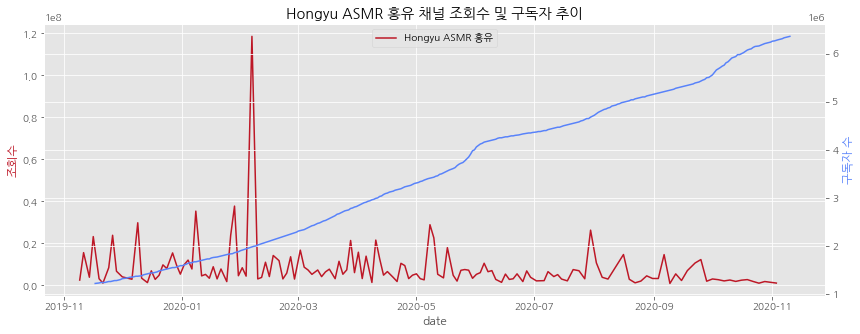

Hot Index(떡상지수): 2.107288230889727


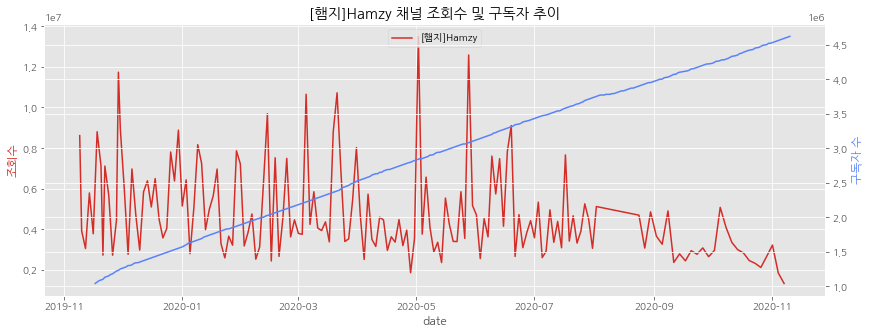

Hot Index(떡상지수): 1.5577113979277037


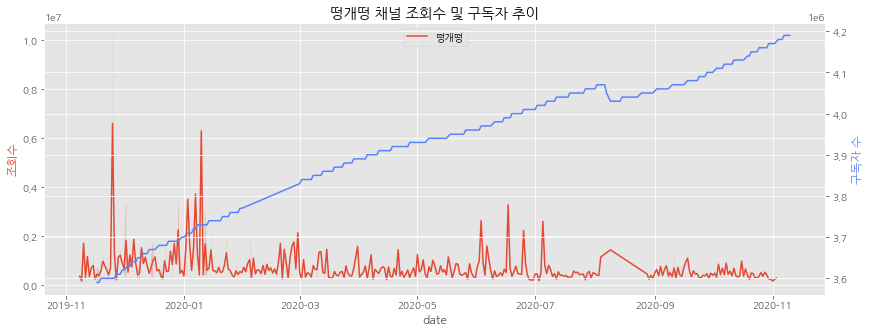

Hot Index(떡상지수): 1.7622230198326705


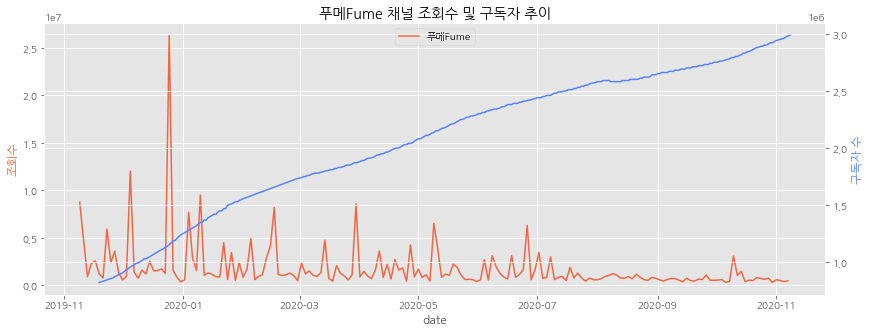

Hot Index(떡상지수): 1.9866030419590883


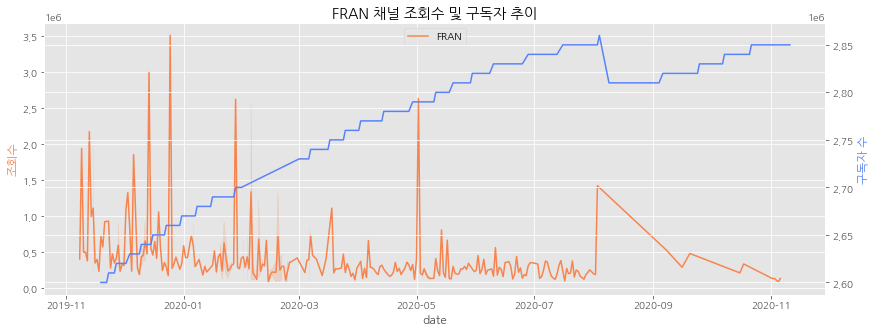

Hot Index(떡상지수): 1.666489514024762


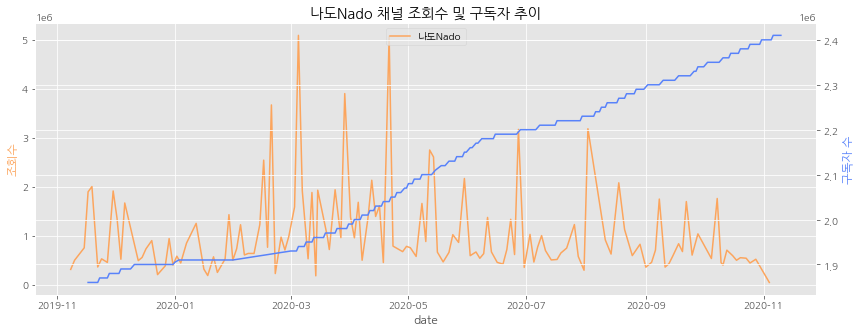

Hot Index(떡상지수): 2.01003332951038


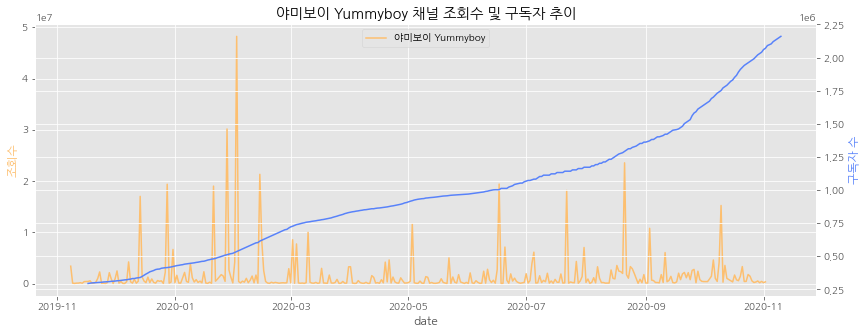

Hot Index(떡상지수): 3.9122083699818835


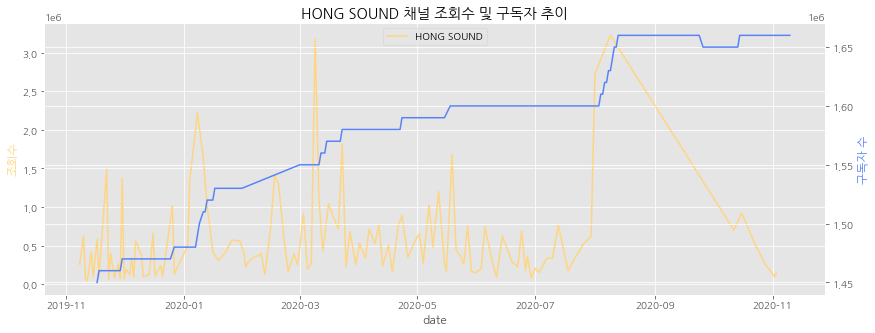

Hot Index(떡상지수): 2.3011437152032754


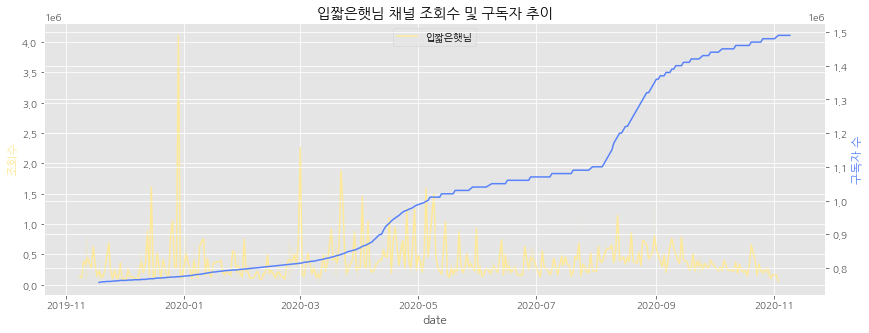

Hot Index(떡상지수): 1.9441218387264194


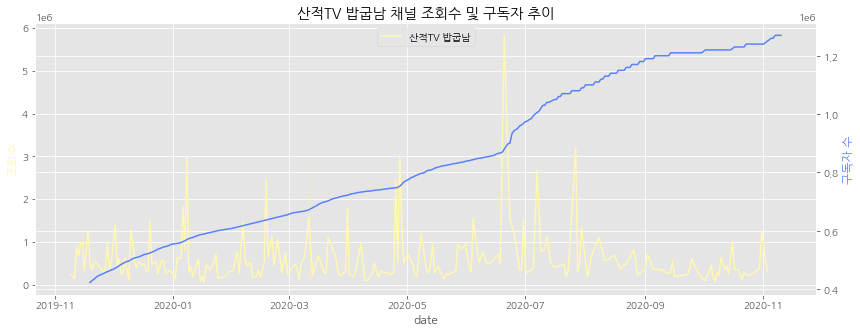

Hot Index(떡상지수): 1.9223697230328831


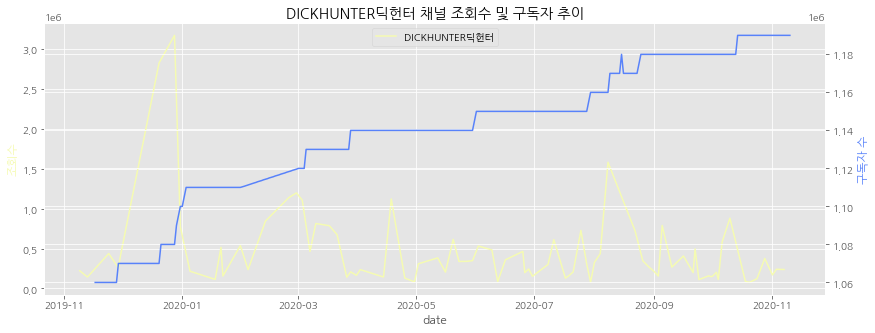

Hot Index(떡상지수): 2.174573211076038


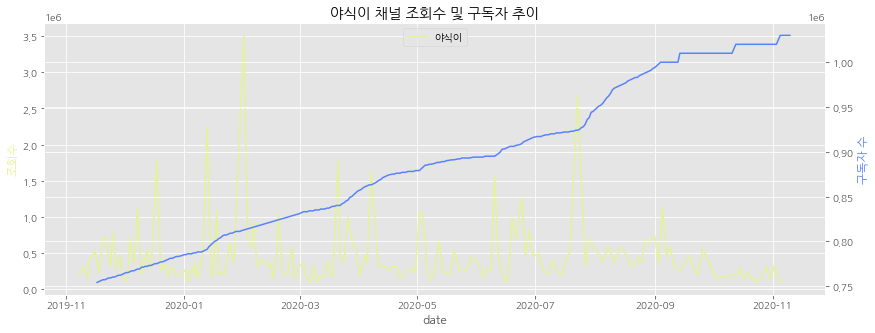

Hot Index(떡상지수): 1.859540673474731


In [27]:
for i in range(len(pop_order)):
    plot_trend_pop(i)

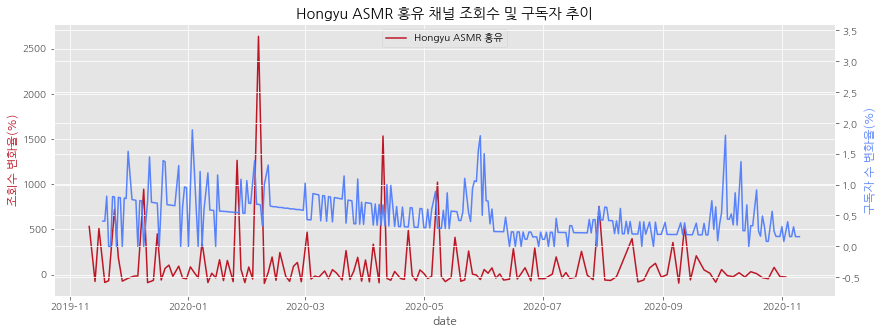

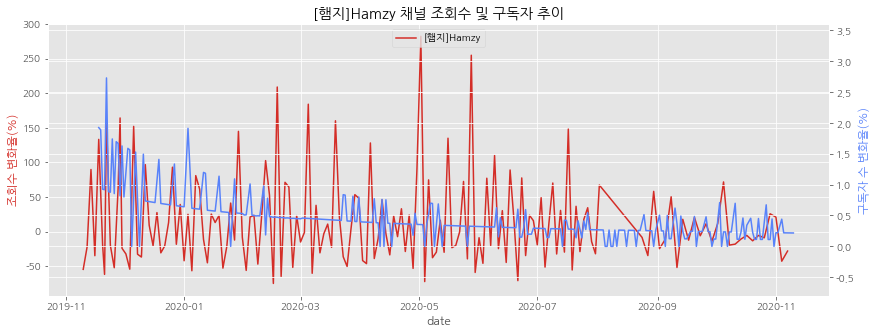

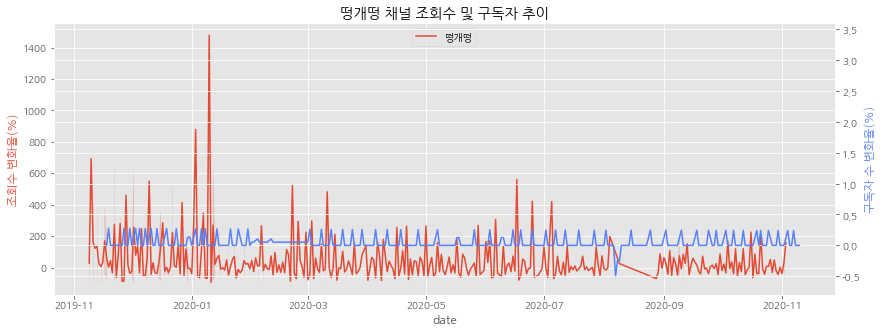

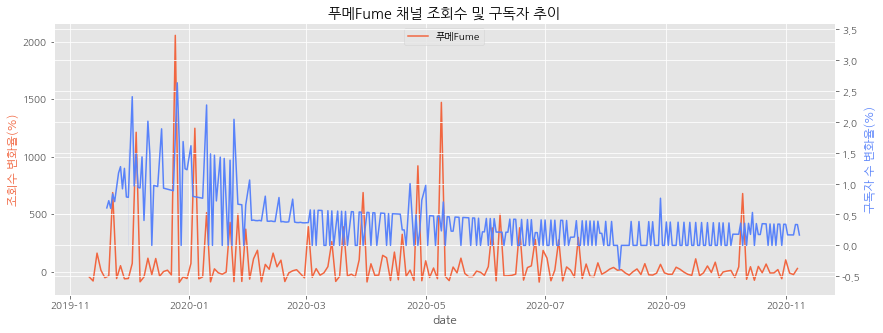

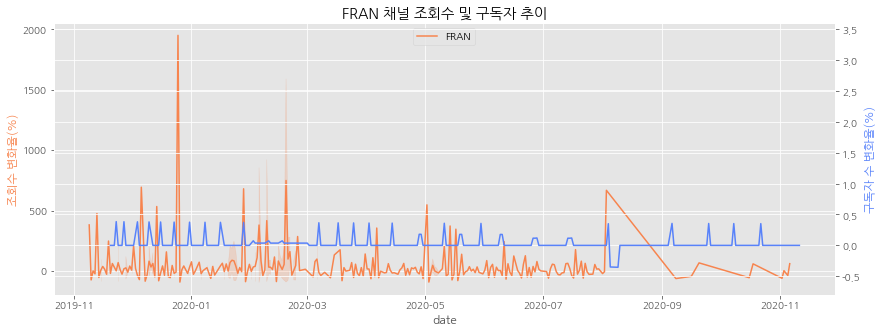

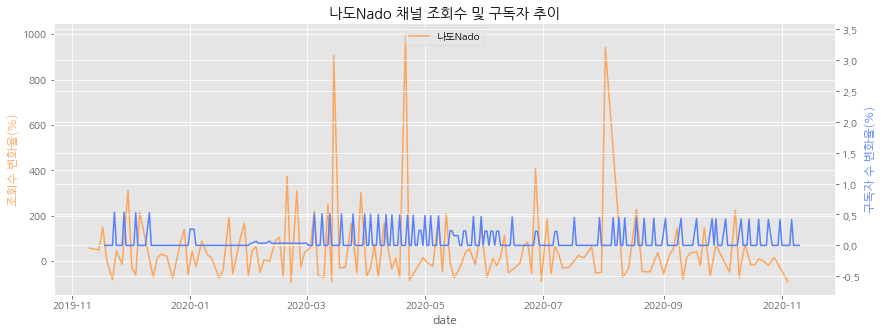

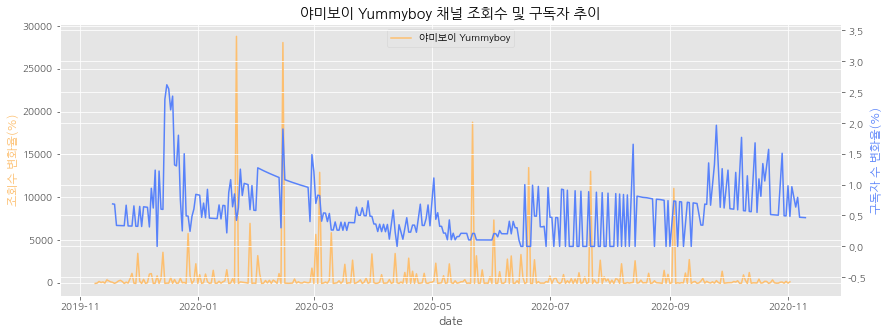

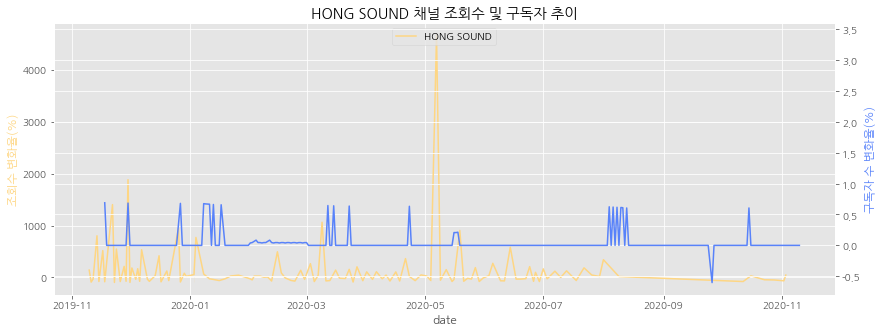

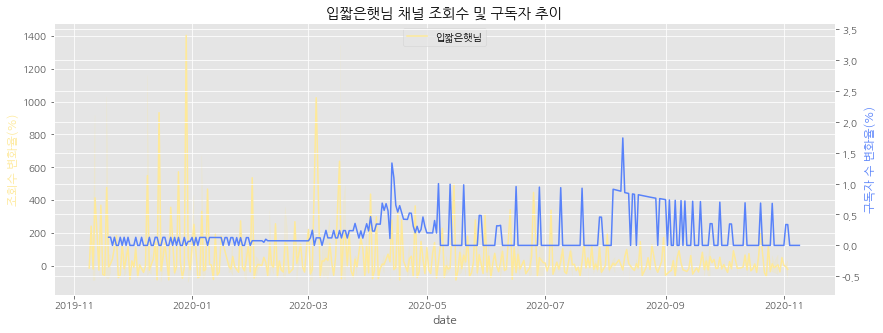

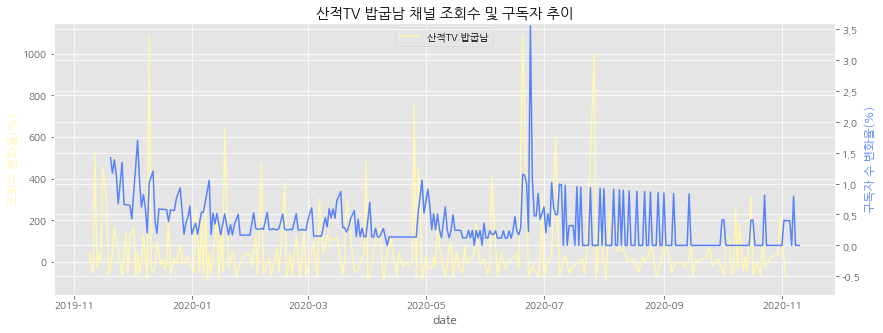

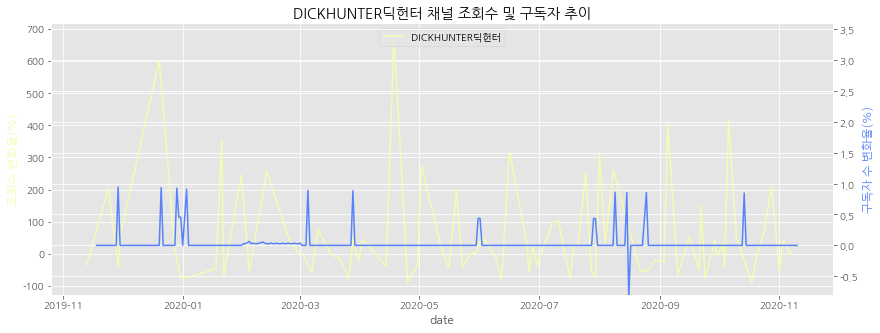

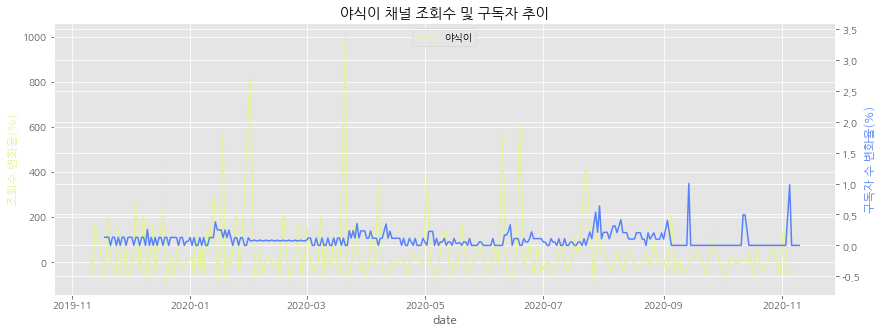

In [28]:
for i in range(len(pop_order)):
    plot_trend_pop_diff(i)

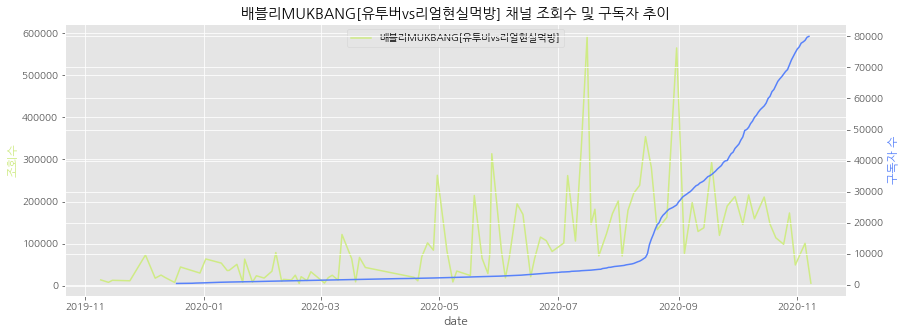

Hot Index(떡상지수): 2.717708342318019


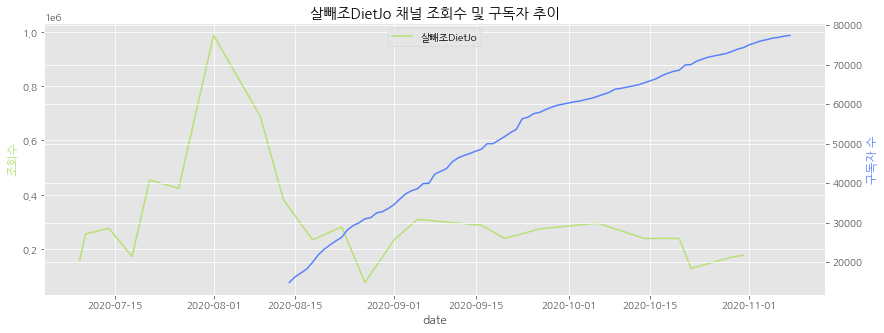

Hot Index(떡상지수): 1.375150314852758


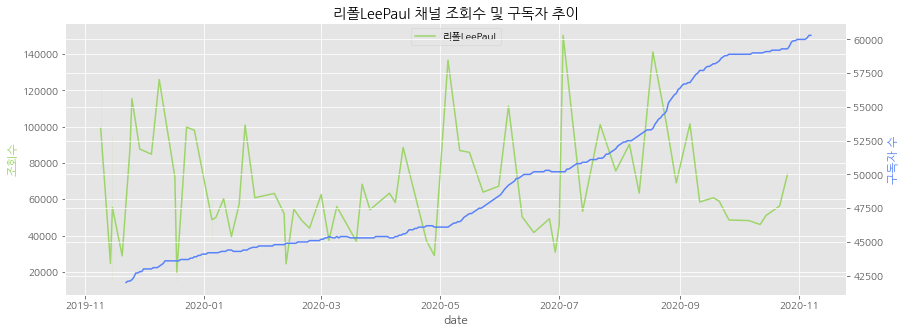

Hot Index(떡상지수): 1.6491615177842343


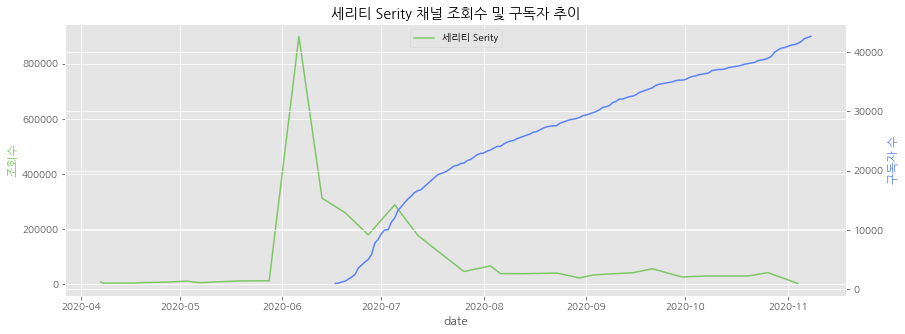

Hot Index(떡상지수): 2.3734063526051545


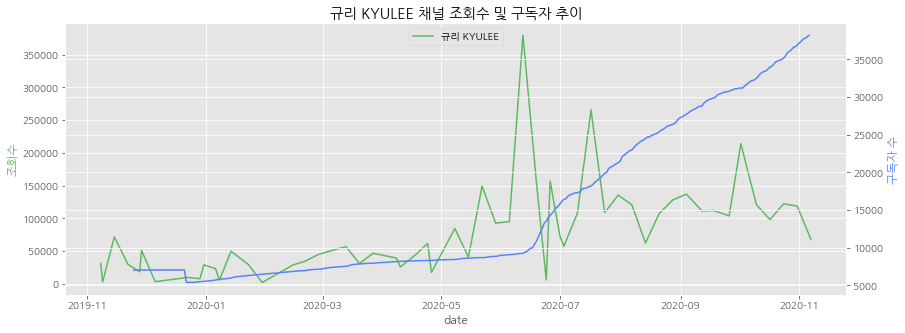

Hot Index(떡상지수): 2.2691774752475244


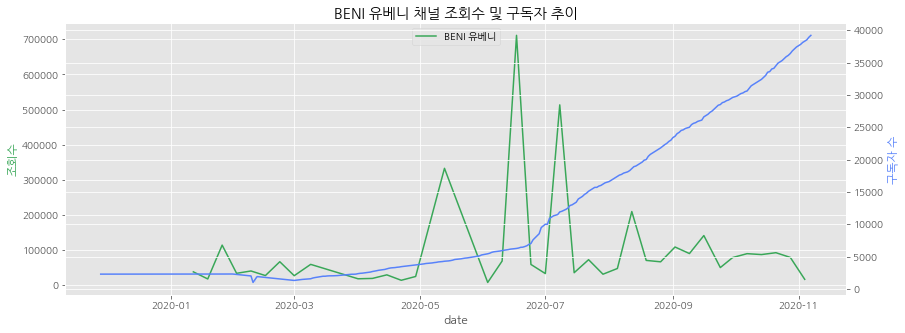

Hot Index(떡상지수): 2.0595635967389354


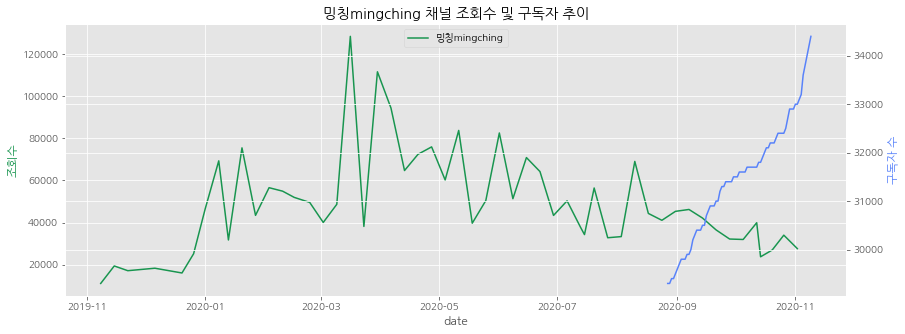

Hot Index(떡상지수): 1.5994527429219034


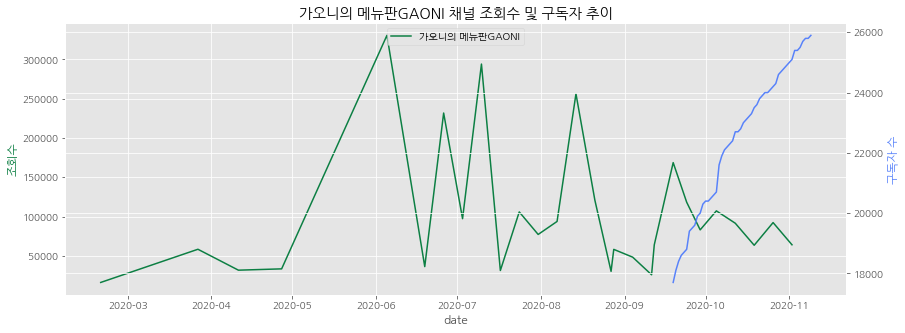

Hot Index(떡상지수): 1.7644885284662006


In [34]:
for i in range(len(unpop_order)):
    plot_trend_unpop(i)

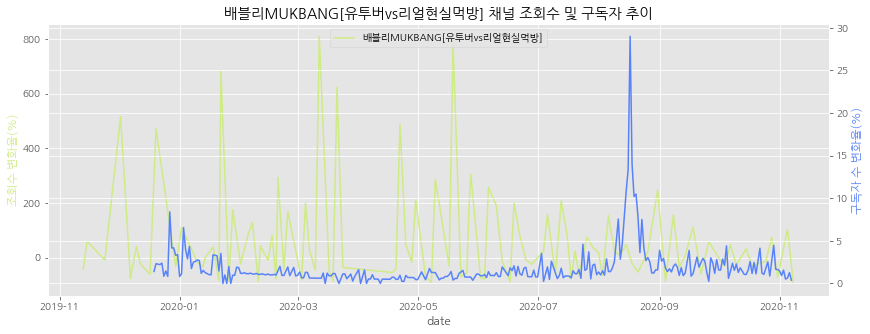

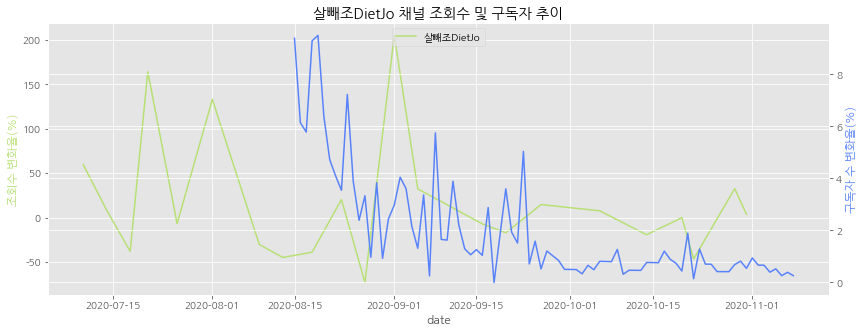

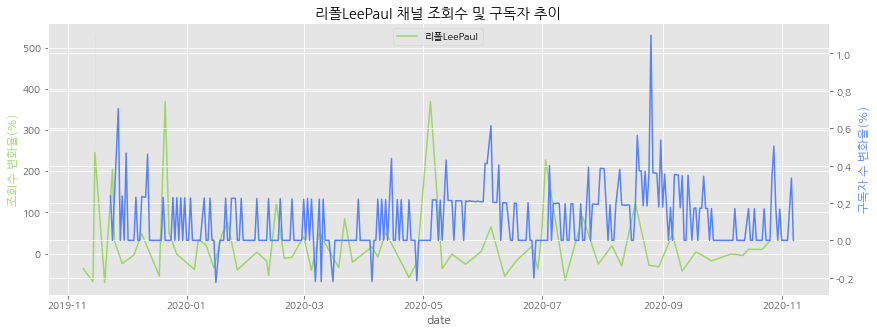

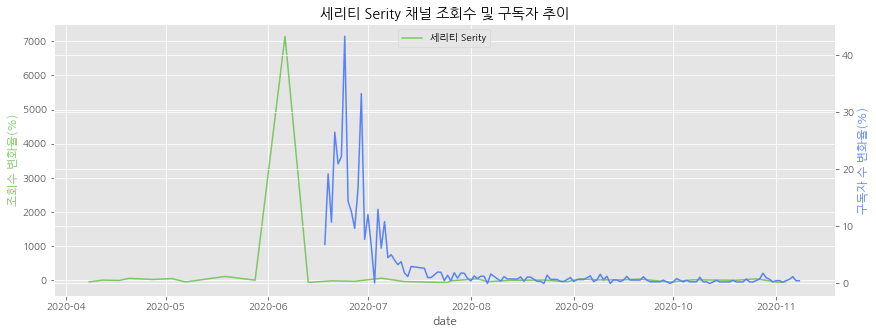

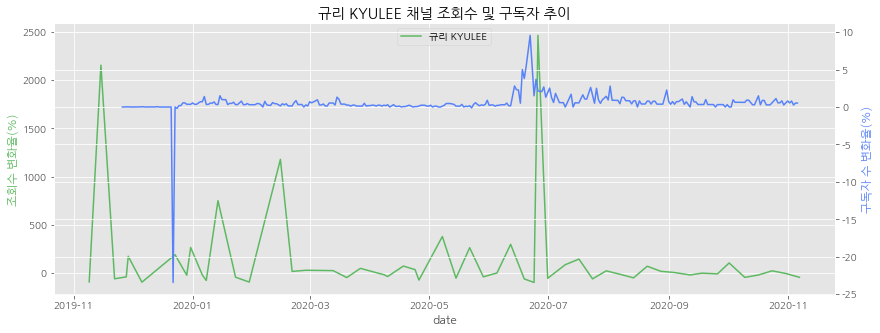

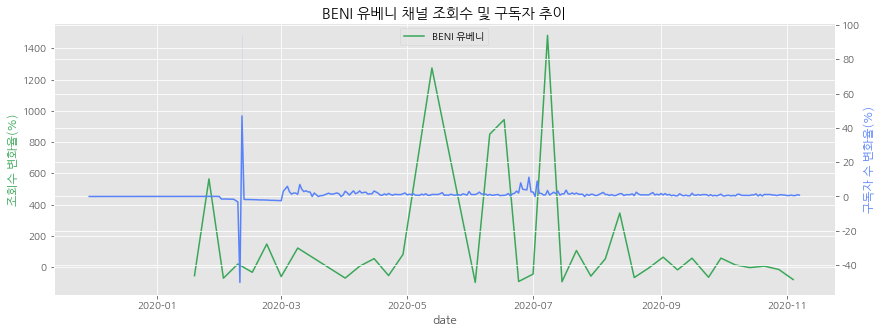

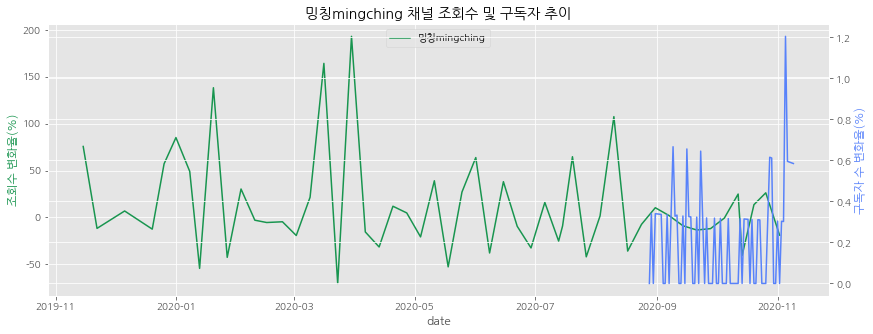

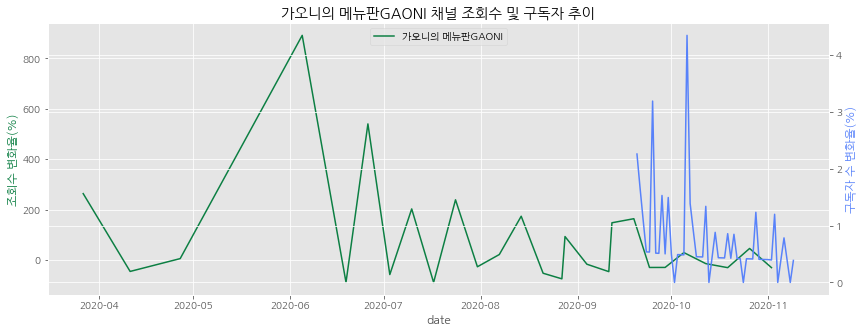

In [32]:
for i in range(len(unpop_order)):
    plot_trend_unpop_diff(i)

In [3]:
def get_trend_unpop(idx=0):
    subs_trend = unpop_trend[unpop_trend['channel']==unpop_order[idx]].reset_index(drop=True)
    subs_trend['diff_ratio'] = ((subs_trend['subscriber'] / subs_trend['subscriber'].shift()) - 1)*100
    view_trend = unpop_current[unpop_current['channel']==unpop_order[idx]]
    n_sub = view_trend['subscribe'].iloc[0] / 10000
    threshold = view_trend[['view']].describe().loc['75%'].values[0]
    
    fig, ax = plt.subplots(figsize=(14, 5))
    
    # 조회수 추이
    sns.lineplot(x='date', y='view', data=view_trend, label=unpop_order[idx], color=unpop_colors[idx], ax=ax)
    ax.set_ylabel('조회수', color=unpop_colors[idx])
    
    # 구독자 수 추이
    ax_twin = ax.twinx()
    sns.lineplot(x='date', y='diff_ratio', data=subs_trend, color='#F5A9D0', ax=ax_twin)
    ax_twin.set_ylabel('구독자 수 변화율(%)', color='#F5A9D0')
    ax_twin.set_ylim(-0.8, 3.6)
#     ax_twin.hlines(y=0, xmin=deadline, xmax=subs_trend['date'].max(), color='gray')
    ax.legend(loc='upper center')

    ax.legend(loc='upper center')
    ax.set_title(f'{unpop_order[idx]} 채널 조회수 및 구독자 추이')
    plt.show()
    print('Hot Index(떡상지수):', threshold / view_trend[view_trend['view'] < threshold][['view']].mean().values[0])

In [202]:
temp = pop_meta[pop_meta['channel']==pop_order[0]]

In [199]:
sub = temp[(temp['date'] >= pd.to_datetime('2019-05-01')) & (temp['date'] < pd.to_datetime('2019-06-01'))]

In [200]:
threshold = temp[['view']].describe().loc['75%'].values[0]

In [194]:
(temp[temp['view'] > threshold][['view']].mean() / temp[temp['view'] <= threshold][['view']].mean().values[0]).values[0]

6.542357827883257

<AxesSubplot:>

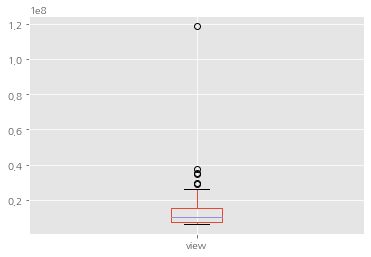

In [205]:
temp[temp['view'] > threshold][['view']].boxplot()

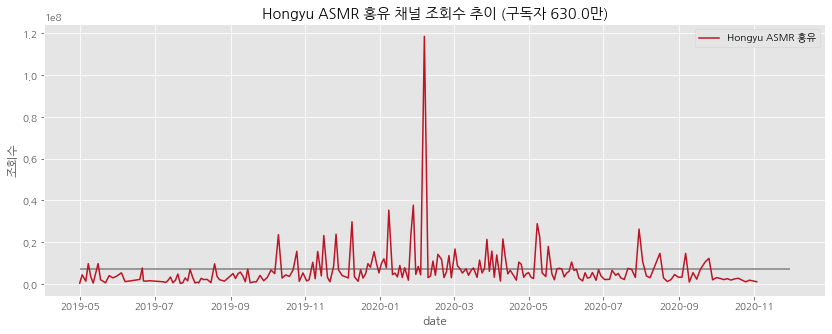

평범한 영상 대비 떡상 영상 조회수 배율: 4.991793352018926


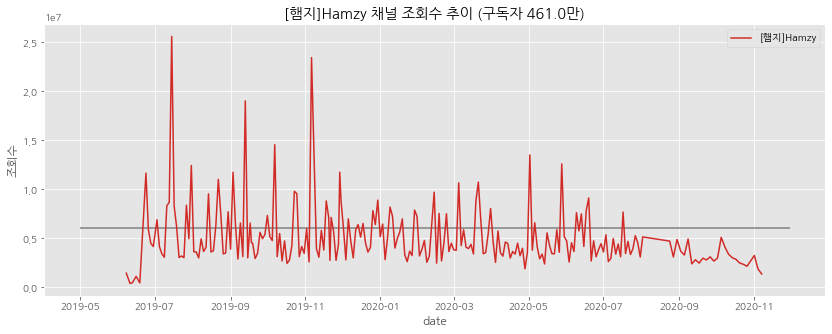

평범한 영상 대비 떡상 영상 조회수 배율: 2.4639867002185767


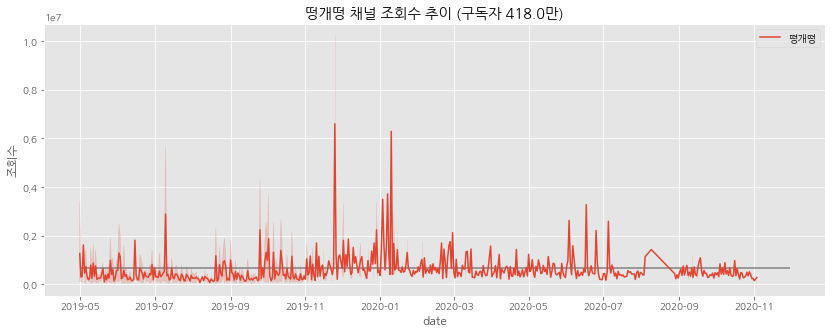

평범한 영상 대비 떡상 영상 조회수 배율: 4.5522945994972455


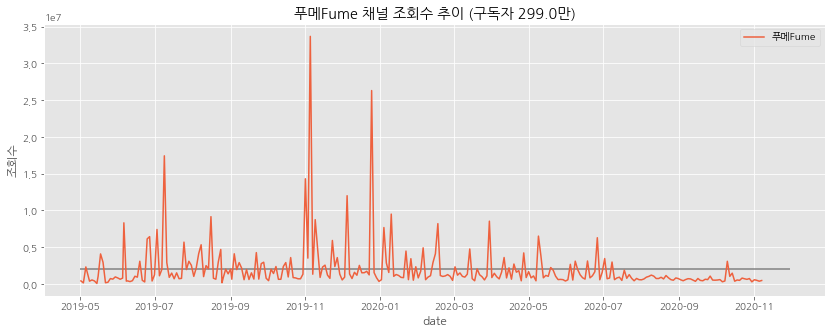

평범한 영상 대비 떡상 영상 조회수 배율: 6.005061511810709


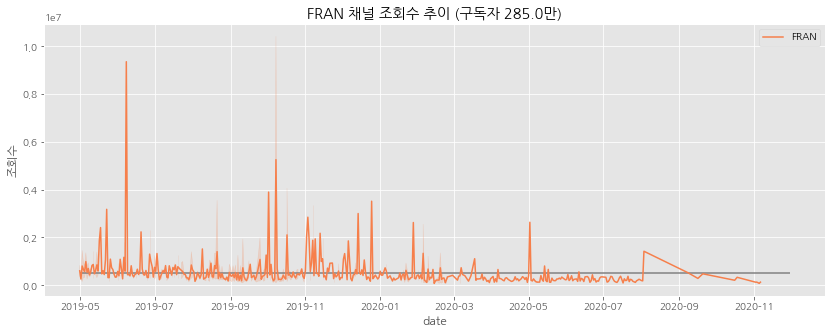

평범한 영상 대비 떡상 영상 조회수 배율: 4.26280038530364


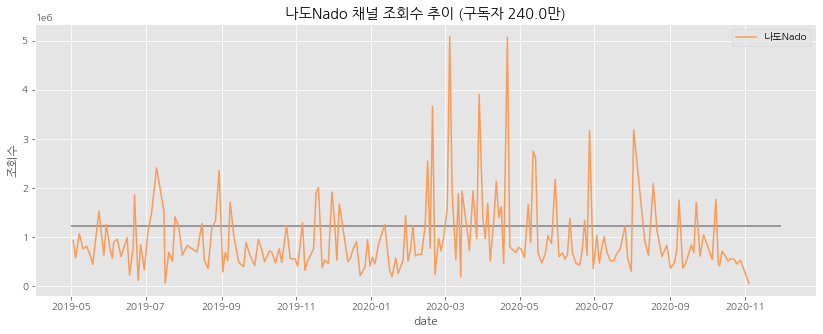

평범한 영상 대비 떡상 영상 조회수 배율: 3.091372373131825


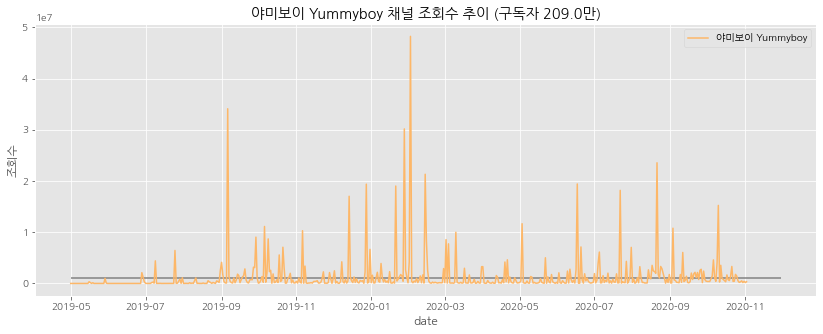

평범한 영상 대비 떡상 영상 조회수 배율: 19.78906148501589


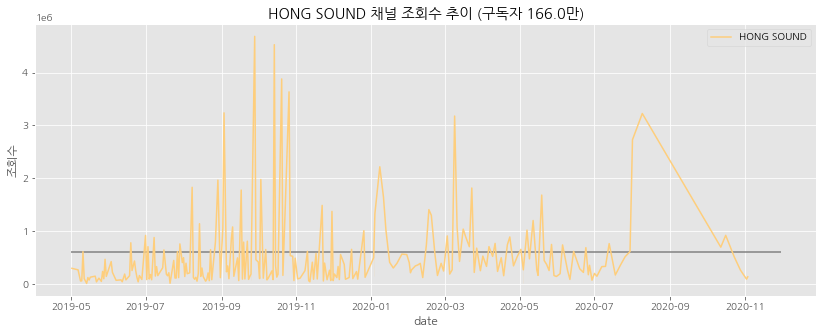

평범한 영상 대비 떡상 영상 조회수 배율: 5.860204268898478


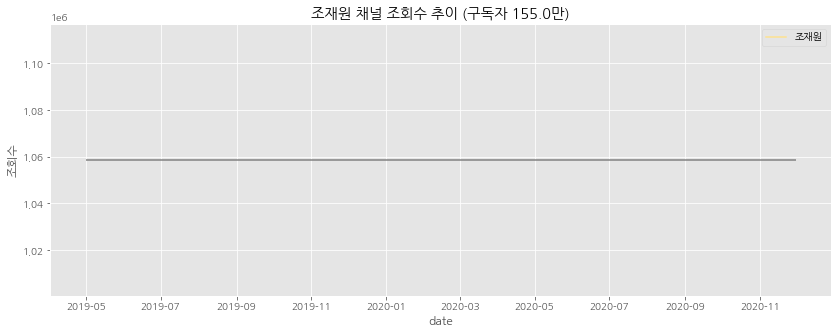

평범한 영상 대비 떡상 영상 조회수 배율: nan


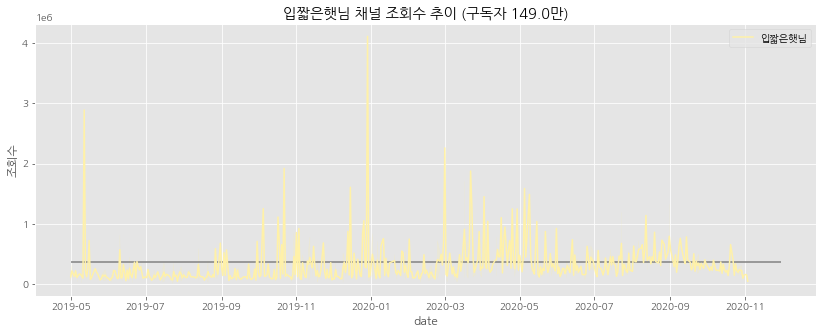

평범한 영상 대비 떡상 영상 조회수 배율: 3.86632460091403


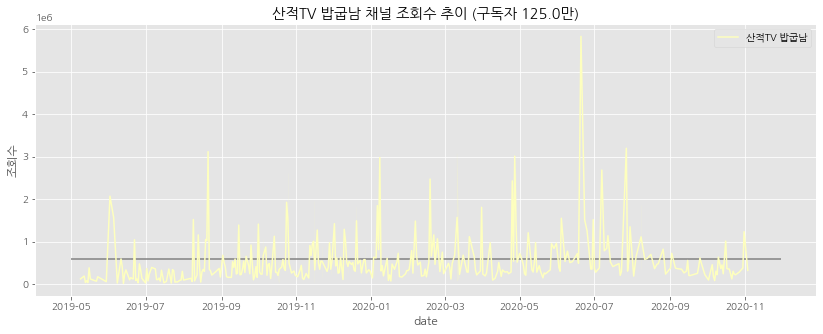

평범한 영상 대비 떡상 영상 조회수 배율: 4.404184461287389


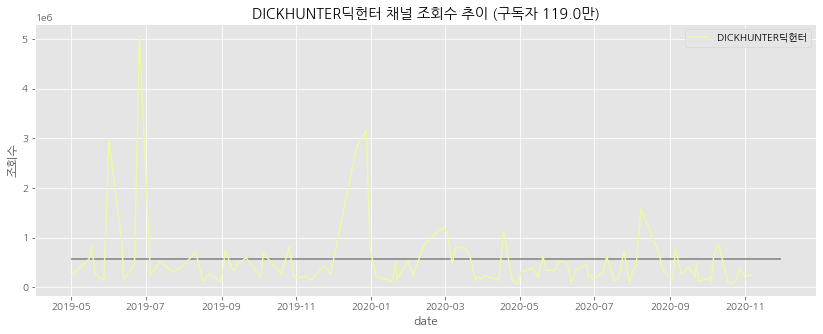

평범한 영상 대비 떡상 영상 조회수 배율: 4.691487221705561


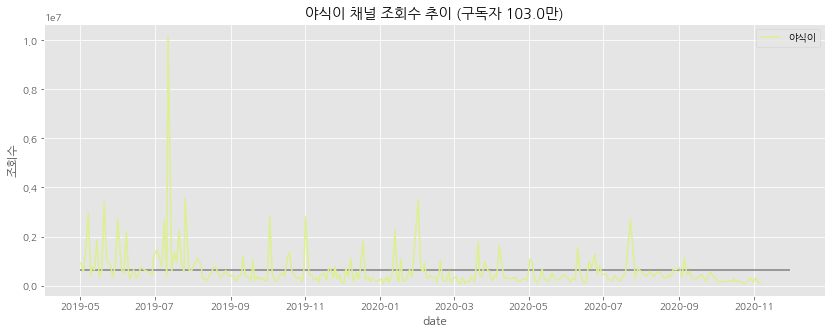

평범한 영상 대비 떡상 영상 조회수 배율: 4.551783212580496


In [197]:
for i in range(13):
    get_view_trend_pop(idx=i)

In [160]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [249]:
temp = pop_meta[pop_meta['channel']==pop_order[5]]
# scaler = MinMaxScaler()
# temp = pd.DataFrame(scaler.fit_transform(temp[['view']]), columns=['view_scaled'])

In [28]:
m = temp['view'].min()
M = temp['view'].max()

In [104]:
stair = int((M - m ) / temp.shape[0])

In [149]:
temp['view']

2626    149939
2627    148128
2628     84109
2629     30823
2630     31754
         ...  
3199    561168
3200    550691
3201    453262
3202    529800
3203     57711
Name: view, Length: 578, dtype: int64

In [175]:
idx = 0
temp = pop_meta[pop_meta['channel']==pop_order[idx]]
threshold_list = list()
freq_list = list()
std_list = list()

i = 1
while True:
    threshold = temp['view'].min() + (stair/2)*i
    subsample = temp[temp['view'] >= threshold]
    freq = subsample.shape[0]
    under = temp[temp['view'] < threshold]
    
    if freq <= 1:
        break
    else:
        threshold_list.append(threshold)
        freq_list.append(freq)
        std_list.append(under['view'].std() / under.shape[0])
        i += 1
print(len(threshold_list))

2996


In [176]:
freq_srs = pd.Series(freq_list)
threshold_srs = pd.Series(threshold_list)
std_srs = pd.Series(std_list)

In [177]:
derive = ((freq_srs - freq_srs.shift()) / 2000).iloc[1:].reset_index(drop=True).to_frame('derivative')

In [178]:
derive['threshold'] = threshold_srs.iloc[1:].reset_index(drop=True)

In [179]:
drastic_point = derive['derivative'].abs().argmax()

In [180]:
plz = derive.loc[drastic_point, 'threshold']

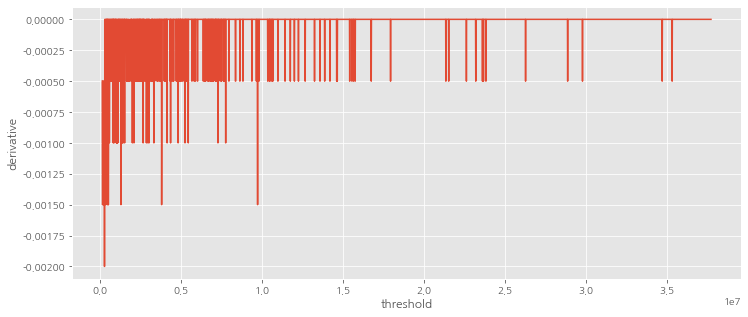

In [181]:
plt.figure(figsize=(12, 5))
sns.lineplot(x='threshold', y='derivative', data=derive)
plt.show()

<AxesSubplot:xlabel='threshold', ylabel='std'>

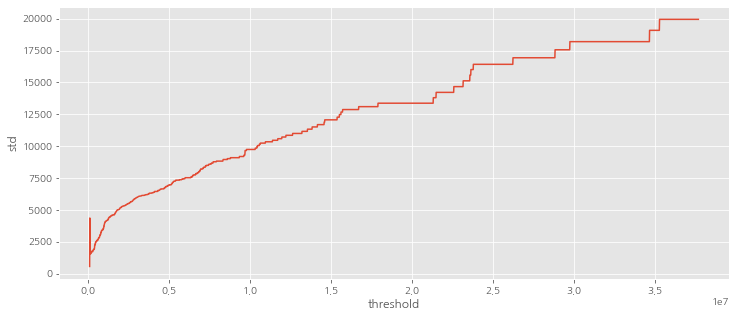

In [182]:
plt.figure(figsize=(12, 5))
result = pd.DataFrame(dict(threshold=threshold_list, std=std_list))
sns.lineplot(x='threshold', y='std', data=result)

<AxesSubplot:xlabel='threshold', ylabel='freq'>

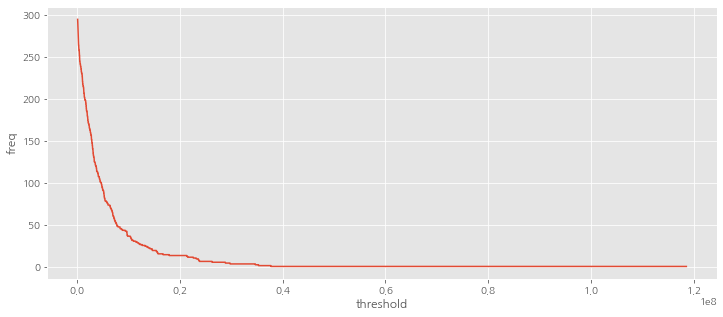

In [236]:
plt.figure(figsize=(12, 5))
result = pd.DataFrame(dict(threshold=threshold_list, freq=freq_list))
sns.lineplot(x='threshold', y='freq', data=result)

<AxesSubplot:xlabel='threshold', ylabel='freq'>

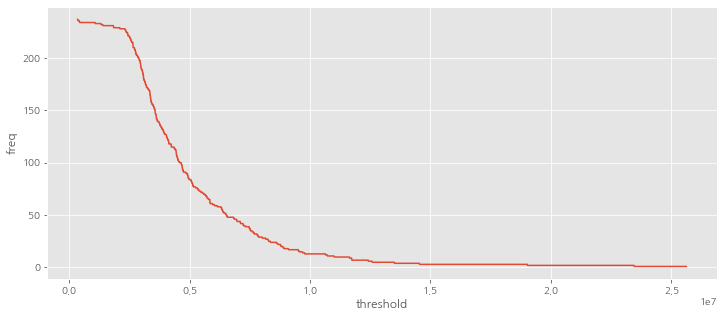

In [239]:
plt.figure(figsize=(12, 5))
result = pd.DataFrame(dict(threshold=threshold_list, freq=freq_list))
sns.lineplot(x='threshold', y='freq', data=result)

<AxesSubplot:xlabel='threshold', ylabel='freq'>

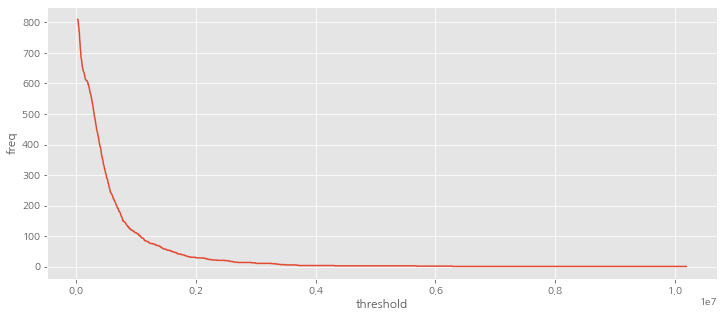

In [242]:
plt.figure(figsize=(12, 5))
result = pd.DataFrame(dict(threshold=threshold_list, freq=freq_list))
sns.lineplot(x='threshold', y='freq', data=result)

<AxesSubplot:xlabel='threshold', ylabel='freq'>

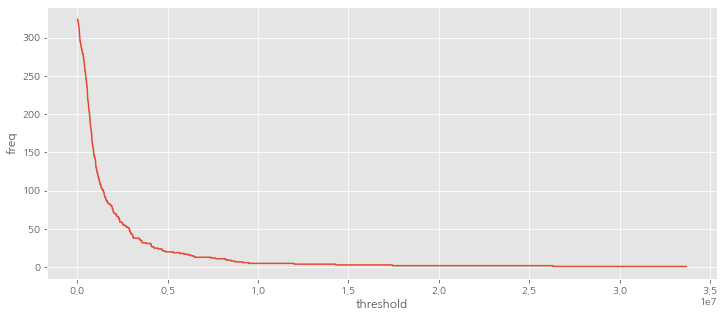

In [245]:
plt.figure(figsize=(12, 5))
result = pd.DataFrame(dict(threshold=threshold_list, freq=freq_list))
sns.lineplot(x='threshold', y='freq', data=result)

<AxesSubplot:xlabel='threshold', ylabel='freq'>

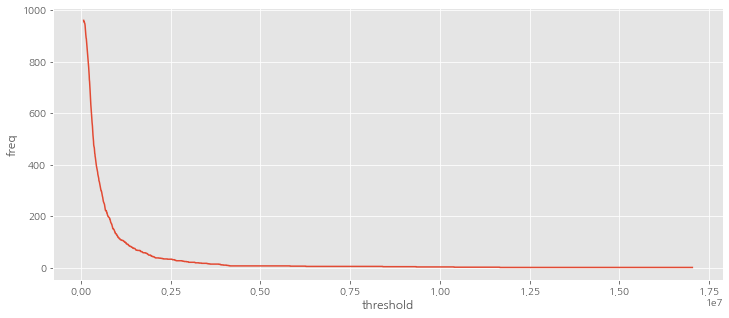

In [248]:
plt.figure(figsize=(12, 5))
result = pd.DataFrame(dict(threshold=threshold_list, freq=freq_list))
sns.lineplot(x='threshold', y='freq', data=result)

In [265]:
stride = 1
filter_size = 14

In [247]:
pd.to_datetime('2018-09-29')

Timestamp('2018-09-29 00:00:00')

In [261]:
origin + timedelta(2)

Timestamp('2018-10-01 00:00:00')

떡상 영상 발생 주기가 필요함

In [253]:
origin = temp['date'][0]

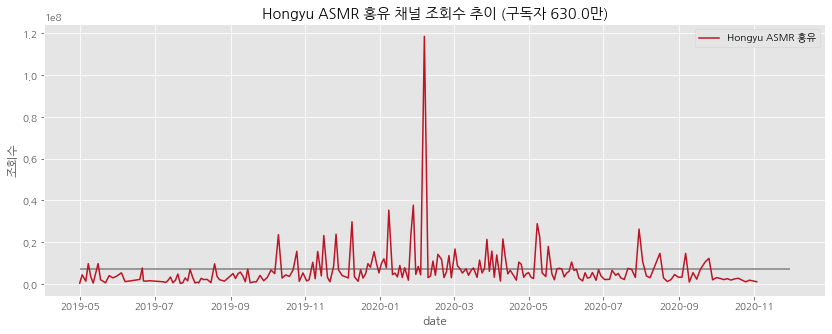

평범한 영상 대비 떡상 영상 조회수 배율: 2.217164753419736


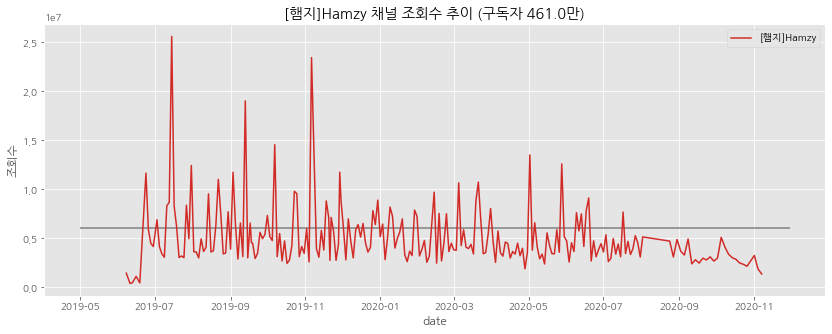

평범한 영상 대비 떡상 영상 조회수 배율: 1.630308450701158


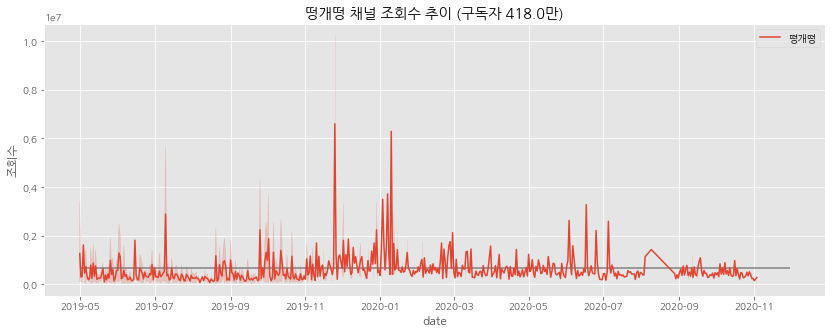

평범한 영상 대비 떡상 영상 조회수 배율: 2.2135716294289605


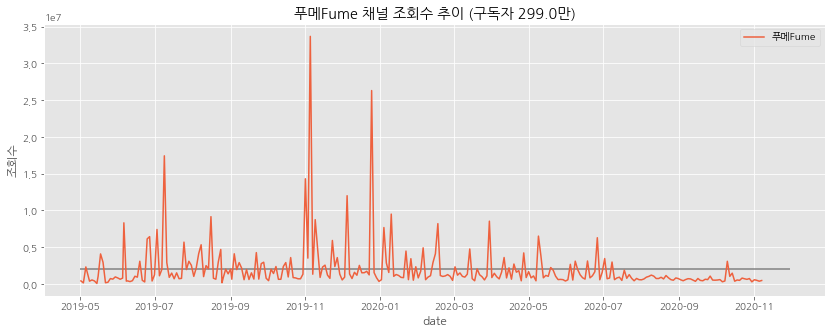

평범한 영상 대비 떡상 영상 조회수 배율: 2.336785526941798


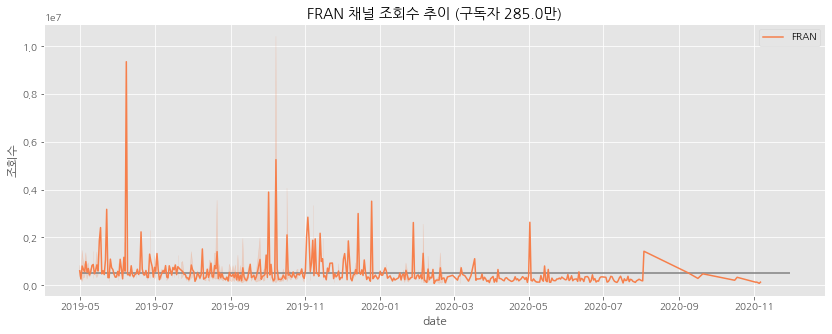

평범한 영상 대비 떡상 영상 조회수 배율: 1.8550065077439597


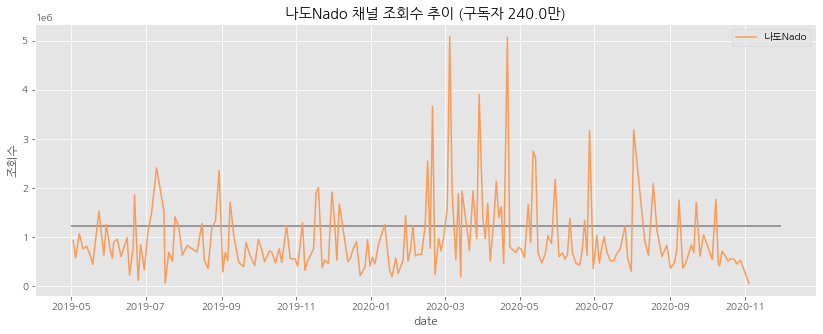

평범한 영상 대비 떡상 영상 조회수 배율: 1.92723415591374


In [102]:
for i in range(6):
    get_view_trend_pop(i)

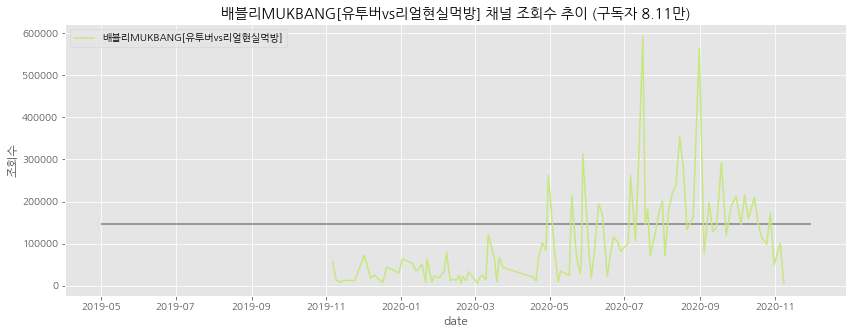

평범한 영상 대비 떡상 영상 조회수 배율: 2.7166972357354995


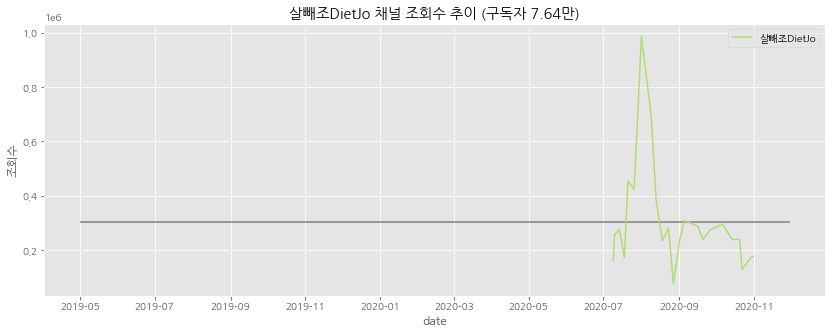

평범한 영상 대비 떡상 영상 조회수 배율: 1.375150314852758


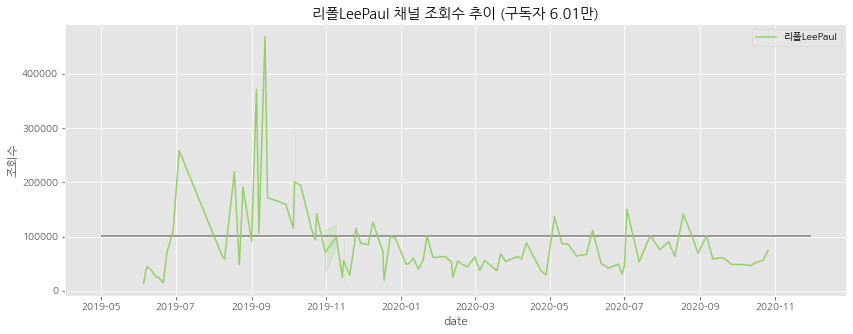

평범한 영상 대비 떡상 영상 조회수 배율: 1.7884641619601103


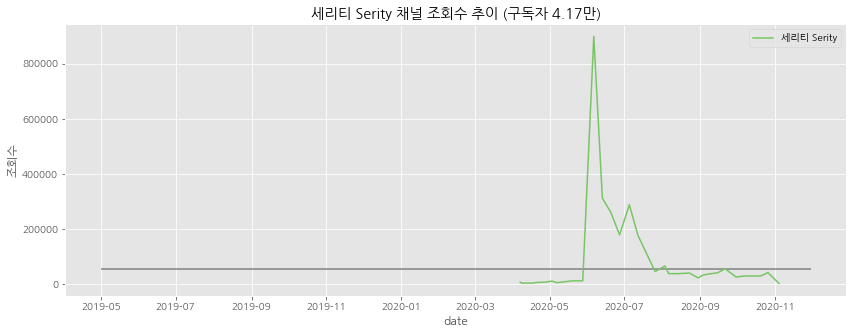

평범한 영상 대비 떡상 영상 조회수 배율: 2.3734063526051545


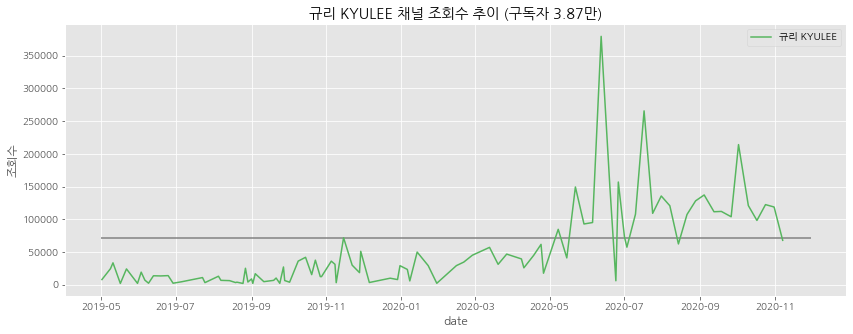

평범한 영상 대비 떡상 영상 조회수 배율: 3.31278281877346


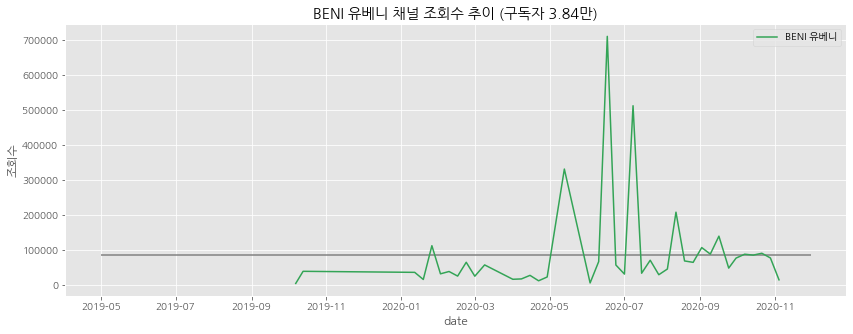

평범한 영상 대비 떡상 영상 조회수 배율: 2.0942543648797063


In [103]:
for i in range(6):
    get_view_trend_unpop(i)

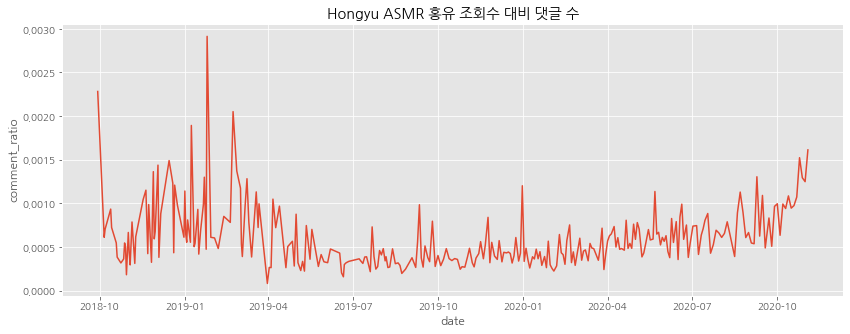

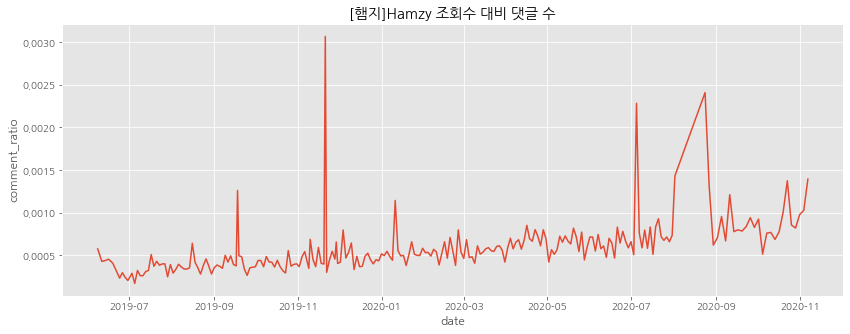

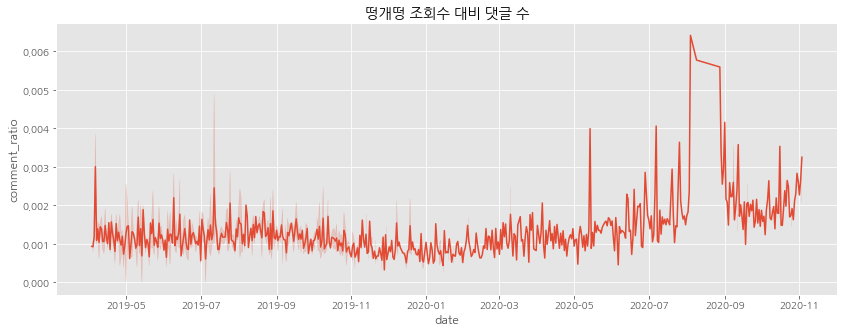

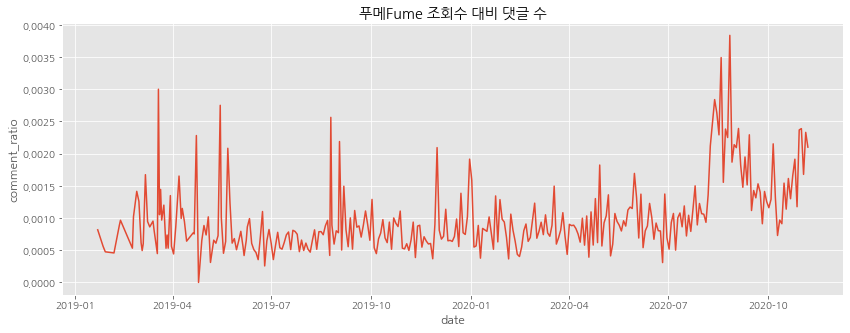

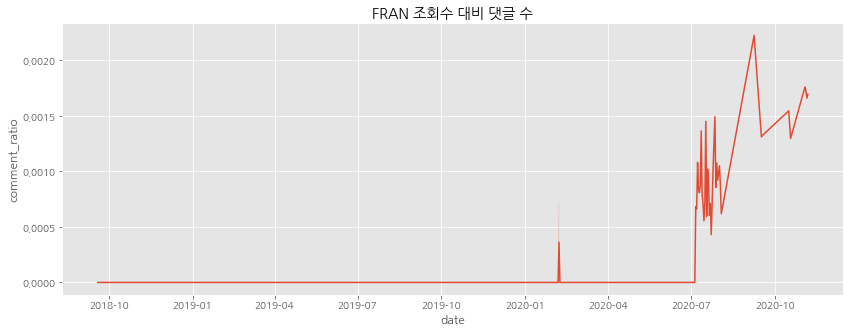

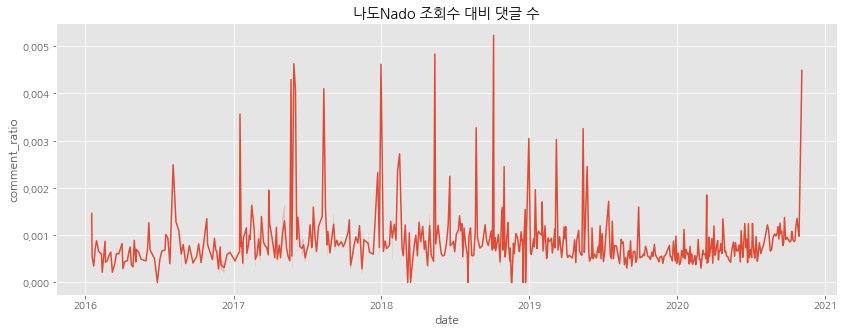

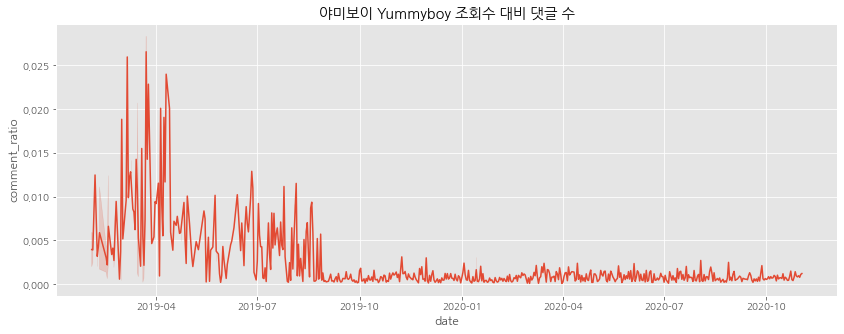

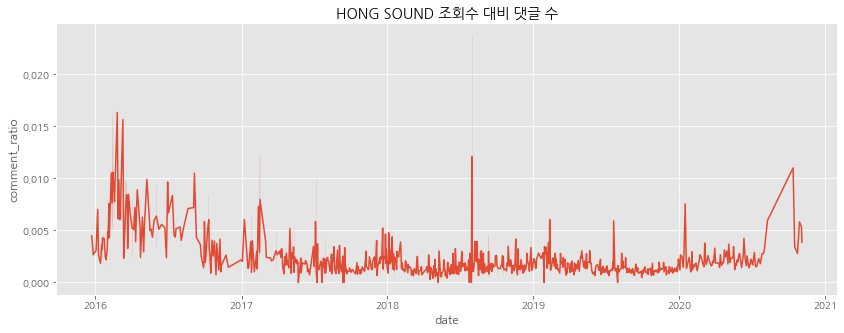

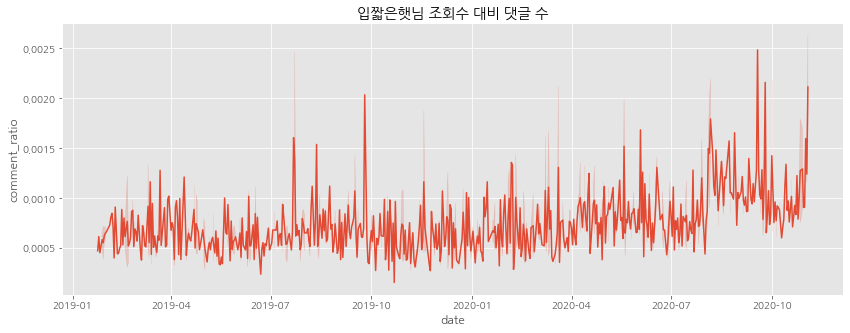

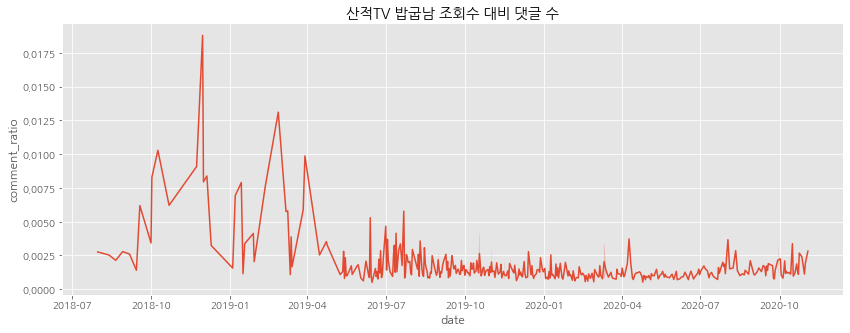

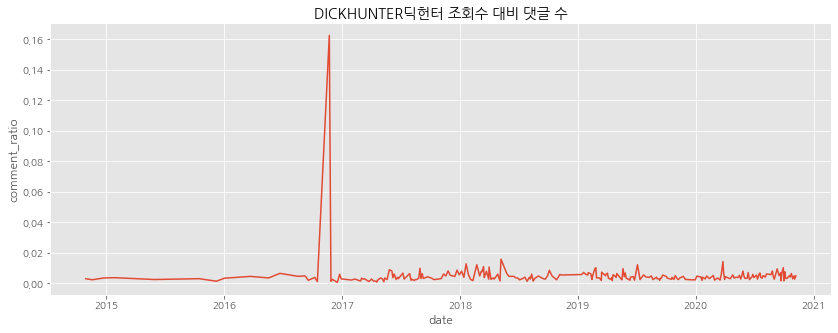

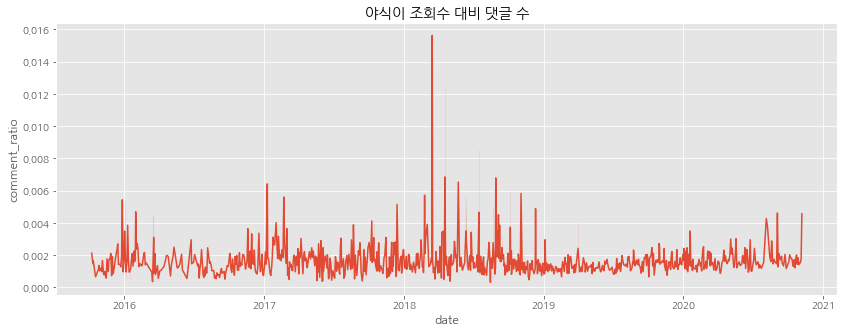

In [77]:
for i in range(len(pop_order)):
    fig, ax = plt.subplots(figsize=(14, 5))

    idx = i
    temp = pop_meta[pop_meta['channel'] == pop_order[idx]].reset_index(drop=True)
    temp['comment_ratio'] = temp['comment'] / temp['view']
    sns.lineplot(x='date', y='comment_ratio', data=temp, ax=ax)

    subs_trend = pop_trend[pop_trend['channel']==pop_order[idx]].reset_index(drop=True)
    subs_trend['diff_ratio'] = ((subs_trend['subscriber'] / subs_trend['subscriber'].shift()) - 1)*100
    # ax_twin = ax.twinx()
    # sns.lineplot(x='date', y='diff_ratio', data=subs_trend, color='gray', ax=ax_twin)
    # ax_twin.set_ylabel('구독자 수 변화율(%)', color='gray')

    ax.set_title(f'{pop_order[idx]} 조회수 대비 댓글 수')
    # plt.xlim(pd.to_datetime('2019-11-01'), pd.to_datetime('2020-11-10'))
    plt.show()

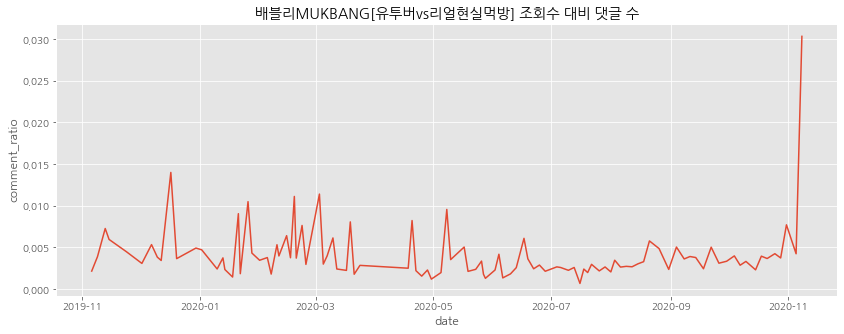

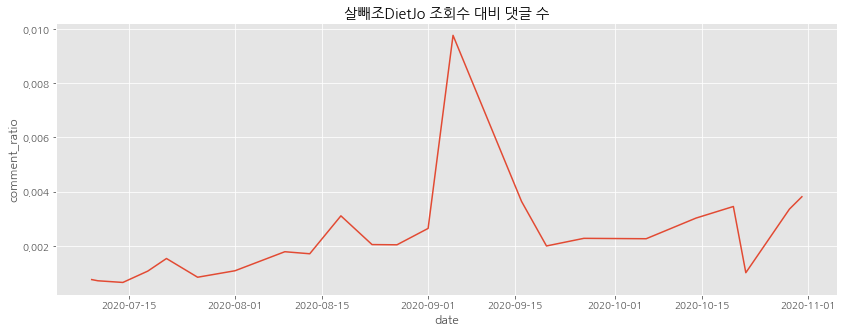

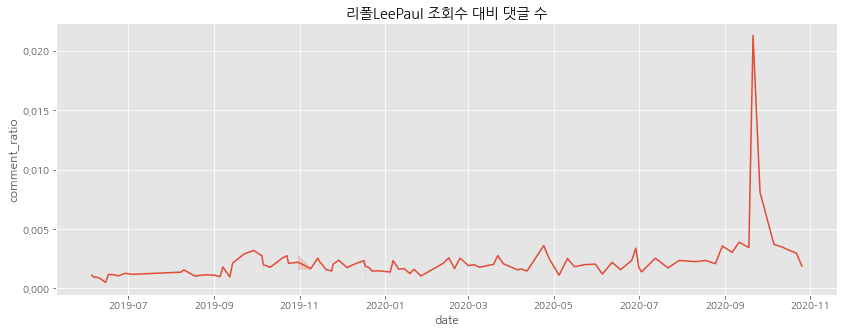

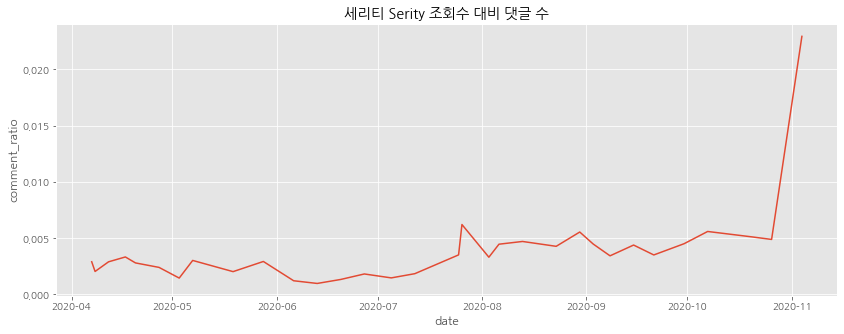

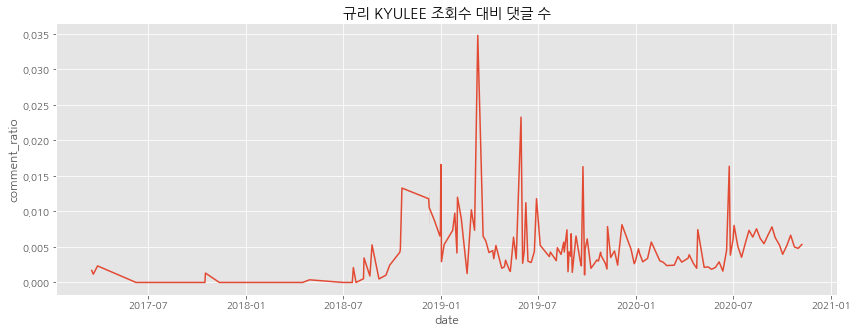

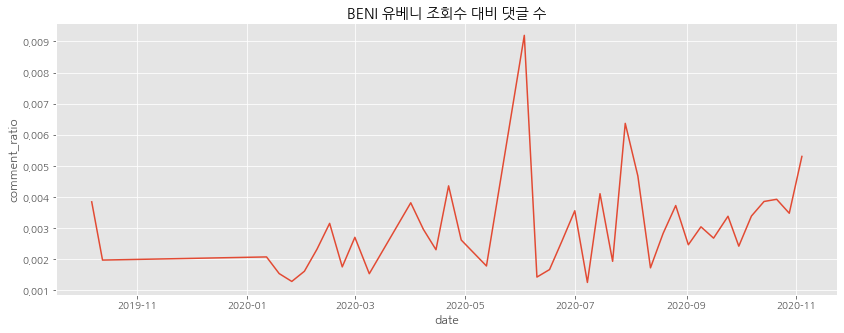

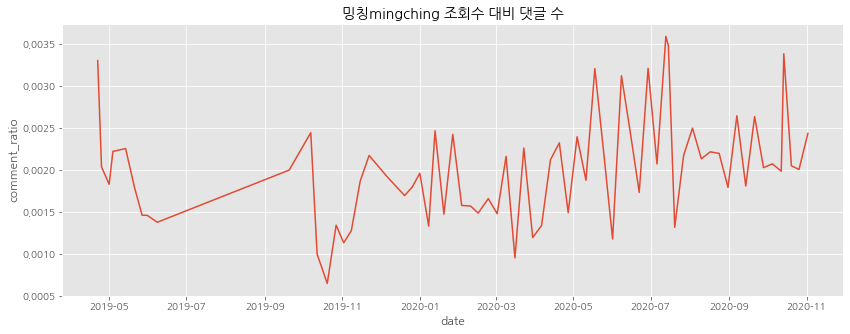

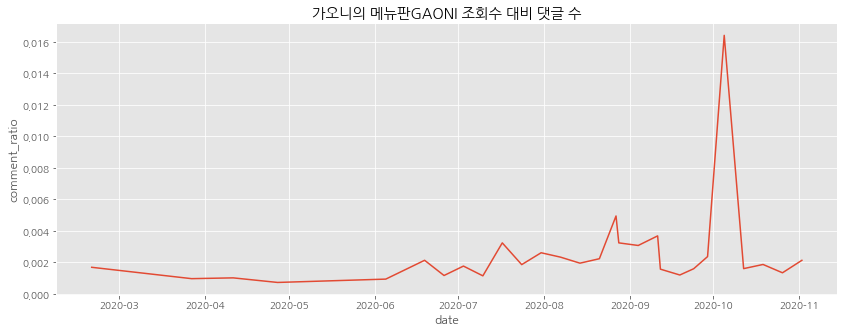

In [78]:
for i in range(len(unpop_order)):
    fig, ax = plt.subplots(figsize=(14, 5))

    idx = i
    temp = unpop_meta[unpop_meta['channel'] == unpop_order[idx]].reset_index(drop=True)
    temp['comment_ratio'] = temp['comment'] / temp['view']
    sns.lineplot(x='date', y='comment_ratio', data=temp, ax=ax)

    subs_trend = unpop_trend[unpop_trend['channel']==unpop_order[idx]].reset_index(drop=True)
    subs_trend['diff_ratio'] = ((subs_trend['subscriber'] / subs_trend['subscriber'].shift()) - 1)*100
    # ax_twin = ax.twinx()
    # sns.lineplot(x='date', y='diff_ratio', data=subs_trend, color='gray', ax=ax_twin)
    # ax_twin.set_ylabel('구독자 수 변화율(%)', color='gray')

    ax.set_title(f'{unpop_order[idx]} 조회수 대비 댓글 수')
    # plt.xlim(pd.to_datetime('2019-11-01'), pd.to_datetime('2020-11-10'))
    plt.show()

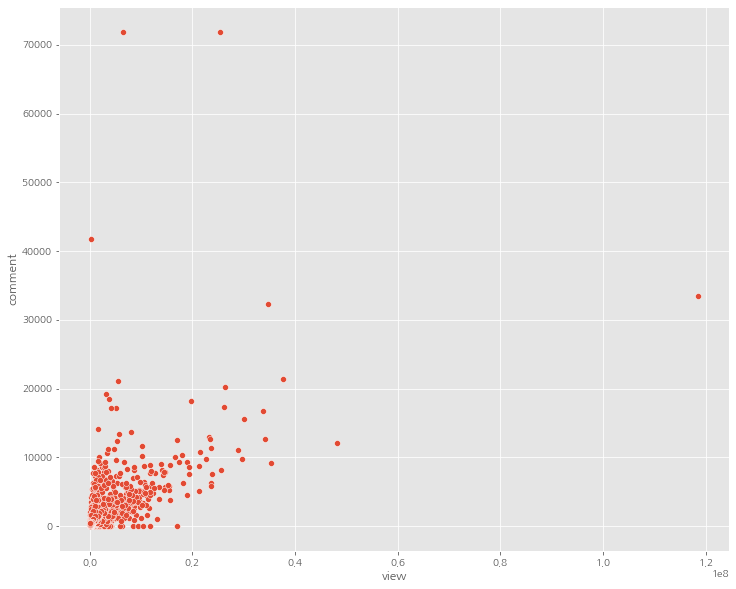

In [85]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x='view', y='comment', data=pop_meta)
plt.show()

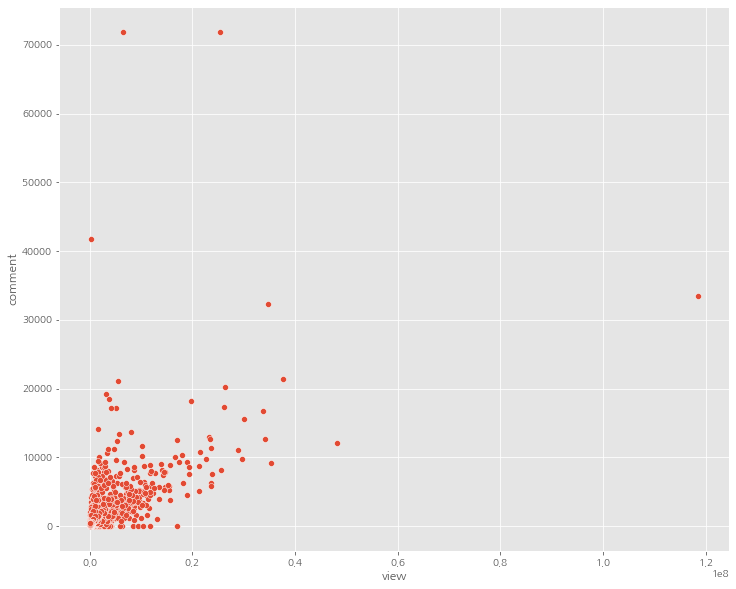

In [88]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x='view', y='comment', data=pop_meta)
plt.show()

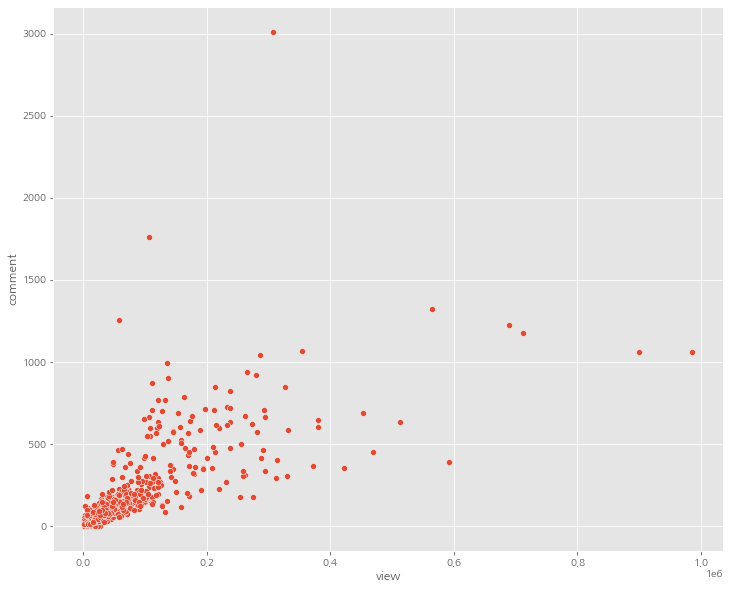

In [84]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x='view', y='comment', data=unpop_meta)
plt.show()

#### deprecated

In [1]:
# def get_trend_unpop(idx=0):
#     view_trend = unpop_current[unpop_current['channel']==unpop_order[idx]]
#     n_sub = view_trend['subscribe'].iloc[0] / 10000
#     threshold = view_trend[['view']].describe().loc['75%'].values[0]

#     plt.figure(figsize=(14, 5))
#     sns.lineplot(x='date', y='view', data= view_trend, label=unpop_order[idx], color=unpop_colors[idx])
#     plt.hlines(y=threshold, xmin=pd.to_datetime('2019-05-01'), xmax=pd.to_datetime('2020-11-30'), color='gray')
#     plt.legend()
#     plt.title(f'{unpop_order[idx]} 채널 조회수 추이 (구독자 {n_sub}만)')
#     plt.ylabel('조회수')
#     plt.show()
#     print('Hot Index(떡상지수):', threshold / view_trend[view_trend['view'] < threshold][['view']].mean().values[0])